In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.rcParams["font.family"] = "DejaVu Sans"

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

import re
import warnings
warnings.filterwarnings('ignore')

# Utils functions

In [2]:
from goatools import obo_parser
from goatools.associations import read_ncbi_gene2go
from goatools.go_enrichment import GOEnrichmentStudy

import wget
import os

from goatools.anno.genetogo_reader import Gene2GoReader
import gzip
from Bio.UniProt.GOA import gafiterator

from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from genes_ncbi_ecoli import GENEID2NT as GeneID2nt_ecoli

#run one time to initialize
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo")

#run one time to initialize
mapper = {}

for key in GeneID2nt_ecoli:
    mapper[GeneID2nt_ecoli[key].Symbol] = GeneID2nt_ecoli[key].GeneID
    
inv_map = {v: k for k, v in mapper.items()}

objanno = Gene2GoReader(fin_gene2go, taxids=[511145])
ns2assoc = objanno.get_ns2assc()

#run one time to initialize
goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_ecoli.keys(), # List of ecoli protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method
GO_items = []

temp = goeaobj.ns2objgoea['BP'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['CC'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['MF'].assoc
for item in temp:
    GO_items += temp[item]

#pass list of gene symbols
def go_it(test_genes):
    print(f'input genes: {len(test_genes)}')
    
    mapped_genes = []
    for gene in test_genes:
        try:
            mapped_genes.append(mapper[gene])
        except:
            print(gene)
    print(f'mapped genes: {len(mapped_genes)}')
    
    goea_results_all = goeaobj.run_study(mapped_genes)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    GO = pd.DataFrame(list(map(lambda x: [x.GO, x.goterm.name, x.goterm.namespace, x.p_uncorrected, x.p_fdr_bh,\
                   x.ratio_in_study[0], x.ratio_in_study[1], GO_items.count(x.GO), list(map(lambda y: inv_map[y], x.study_items)),\
                   ], goea_results_sig)), columns = ['GO', 'term', 'class', 'p', 'p_corr', 'n_genes',\
                                                    'n_study', 'n_go',  'study_genes'])
    
    return GO

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms
HMS:0:01:32.337815  41,224 annotations,  3,849 genes,  4,117 GOs, 1 taxids READ: gene2go 

Load BP Ontology Enrichment Analysis ...
 71%  3,298 of  4,640 population items found in association

Load CC Ontology Enrichment Analysis ...
 65%  3,002 of  4,640 population items found in association

Load MF Ontology Enrichment Analysis ...
 70%  3,243 of  4,640 population items found in association


In [3]:
# Utils functions


def plot_broken(ax_top, ax_bot, col, label, color, break_val_up, break_val_down):
    y = means[col]
    yerr = errors[col]
    x = means["expression_level"]

    mask_top = y >= break_val_up
    mask_bottom = y < break_val_down

    # Plot bottom first
    ax_bot.errorbar(x[mask_bottom], y[mask_bottom], yerr=yerr[mask_bottom], fmt='-o', label=label, color=color)
    ax_top.errorbar(x[mask_top], y[mask_top], yerr=yerr[mask_top], fmt='-o', label=label, color=color)

    if any(mask_top):
        max_top = y.max() + yerr.max()
        ax_top.set_ylim(break_val_up, max_top )  # small headroom
    else:
        ax_top.set_ylim(break_val_up, break_val_up * 1.5)

    if any(mask_bottom):
        max_bot = (y[mask_bottom] + yerr[mask_bottom]).max()
        ax_bot.set_ylim(0, max_bot * 1.1)
    else:
        ax_bot.set_ylim(0, break_val_down)

    # Add break markers
    ax_top.plot([0, 1], [0, 0], transform=ax_top.transAxes, **kwargs)
    ax_bot.plot([0, 1], [1, 1], transform=ax_bot.transAxes, **kwargs)

    ax_top.spines['bottom'].set_visible(False)
    ax_bot.spines['top'].set_visible(False)
    ax_top.tick_params(labelbottom=False, bottom=False)

def standardize_mean_differences(df1, df2, use_pooled=True):
    mean1, mean2 = df1.mean(), df2.mean()
    if use_pooled:
        t, p = ttest_ind(df1, df2, equal_var = True)
    else:
        t, p = welch_ttest(df1, df2,)
   
    return t, p

def welch_ttest(x, y): 
    t, p = ttest_ind(x, y, equal_var = False)
    return t, p

def remove_brackets(text):
    # Regex to find a [ followed by any characters until a closing ], at the end of the string
    pattern = r'\[[^\]]*\]$'
    # Replace the found pattern with an empty string
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

def split_molecules_by_function(decreasing):
    monomers = []
    complex = []
    others = []
    rna = []
    peptide = []
    for x in decreasing:
        if x.endswith('MER[c]') or x.startswith('PROTEIN') or x.startswith('PHOSPHO')   or x.startswith('PC') or x.endswith('PROTEIN') or x.endswith('PROTEIN[j]') or x.endswith('PROTEIN[o]') or x.endswith('MER[l]') or x.endswith('MER[j]') or x.startswith('MONOMER') or x.endswith('MER[o]') or x.endswith('MER[e]') or x.endswith('MER[m]') or x.endswith('MER[p]') or x.endswith('MER[i]'):
            monomers.append(remove_brackets(x))
        elif x.endswith('CPLX[c]') or x.endswith('CPLX[p]') or x.endswith('CPLX[m]') or x.endswith('CPLX[i]') or x.endswith('CPLX[o]') or x.startswith('CPLX'):
            complex.append(remove_brackets(x))
        elif x.endswith('RRNA[c]') or x.endswith('RRNA[i]') or x.endswith('tRNA[c]') or x.startswith('RNA'):
            rna.append(remove_brackets(x))
        elif x.startswith('PD'):
            peptide.append(remove_brackets(x))
        else:
            others.append(remove_brackets(x))
    return monomers, complex, others, rna, peptide

def compare_concentrations(dfw, dfg, significant_molecules):
    direction_of_change = {}
    for molecule in significant_molecules:
        mean_wildtype = dfw[molecule].mean()
        mean_mutated = dfg[molecule].mean()
        if mean_mutated > mean_wildtype:
            direction_of_change[molecule] = 'Increase'
        elif mean_mutated < mean_wildtype:
            direction_of_change[molecule] = 'Decrease'
        else:
            direction_of_change[molecule] = 'No Change'
    return direction_of_change

# Function to find the most general terms among a set of related terms
def find_most_general_terms(terms, gosubdag):
    general_terms = set(terms)  # Start with all terms considered as general
    for term in terms:
        # Get all children of each term in the subset graph
        children = gosubdag.rcntobj.go2descendants.get(term, set())
        # Remove any term that is a child of another term from the set of general terms
        general_terms.difference_update(children)
    return general_terms

# Calculate Jaccard similarity
def jaccard_similarity(list1, list2):
    intersection = len(set(list1).intersection(set(list2)))
    union = len(set(list1).union(set(list2)))
    return intersection / union if union != 0 else 0


# Without metabolic pathway

## Data for KIs without the metabolic pathway

In [4]:
df1 = pd.read_pickle("/bm_mean_onlyKIs_noMeta_2025_01_08_1559.pkl")
df2 = pd.read_pickle("/bm_mean_onlyKIs_noMeta_2025_01_08_1600.pkl")
df3 = pd.read_pickle("/bm_mean_onlyKIs_noMeta_2025_01_08_1601.pkl")
mass_df  = pd.read_pickle("/mass_mean_over.pkl").drop(columns=['cell_mass', 'cell_volume', 'growth', 'variant', 'generation'])

df = pd.concat([df1, df2, df3])
df["seed"] = df["cell_path"].str.split("/").str[8]
dfc = df.merge(mass_df, on='cell_path', how='left')
df = dfc.copy()

In [5]:
def mean_list(lst):
    return np.nanmean(lst)
    
for c in  ["cell_mass", "cell_volume", "growth"]:
    df[c] = df[c].apply(mean_list)


In [6]:
print("For each KI expression level and KOs pair, the total number of seeds simulated is: ", df[df["generation"]=="generation_000000"].groupby(["expression_level", "tr_efficiency"])["seed"].count(),
     "And the total number of seeds that reach generation 12 is: ", df[df["generation"]=="generation_000019"].groupby(["expression_level", "tr_efficiency"])["seed"].count())

For each KI expression level and KOs pair, the total number of seeds simulated is:  expression_level  tr_efficiency
1                 1                20
10                1                20
100               1                20
1000              1                20
10000             1                20
100000            1                20
1000000           1                20
10000000          1                20
100000000         1                20
1000000000        1                20
Name: seed, dtype: int64 And the total number of seeds that reach generation 12 is:  expression_level  tr_efficiency
1                 1                18
10                1                18
100               1                19
1000              1                19
10000             1                18
100000            1                17
1000000           1                18
10000000          1                 4
Name: seed, dtype: int64


In [7]:
cols = df.drop(columns=["cell_path", "time", "variant",
       "generation", "expression_level", "tr_efficiency", "seed"]).columns

gens = ['generation_000011',
        'generation_000012', 'generation_000013',
        'generation_000014', 'generation_000015',
        'generation_000016', 'generation_000017',
        'generation_000018', 'generation_000019'
        
        ]
df = df[df['generation'].isin(gens)]
df['growth'] = df['growth']*3600
dfg = df.drop(columns=["cell_path", "time", "variant", "generation"]).groupby(["expression_level", "tr_efficiency", "seed"])[cols].mean().reset_index()


In [8]:
df_gs = dfg.groupby(["expression_level", "tr_efficiency"])[cols].mean().reset_index()
mapping = {"1":"$10^0$", "10":"$10^1$", "100":"$10^2$", "1000":"$10^3$", "10000":"$10^4$", "100000":"$10^5$", "1000000":"$10^6$", 
           "10000000":"$10^7$", "100000000":"$10^8$", "1000000000":"$10^9$", "10000000000":"$10^10$",}
df_gs["expression_level"] = df_gs["expression_level"].map(mapping)

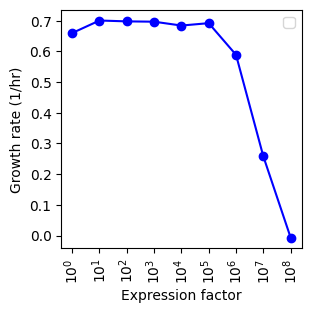

In [9]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(df_gs["expression_level"], df_gs["growth"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("Growth rate (1/hr)")
plt.xticks(rotation = 90)
plt.legend()

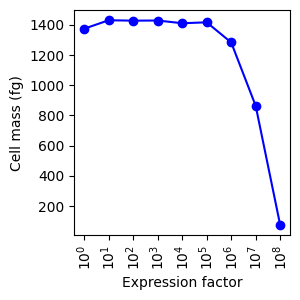

In [10]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(df_gs["expression_level"], df_gs["cell_mass"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("Cell mass (fg)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('cell_mass.png', dpi=300)

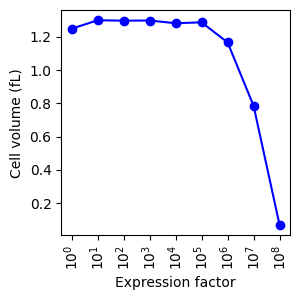

In [11]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(df_gs["expression_level"], df_gs["cell_volume"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("Cell volume (fL)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('cell_volume.png', dpi=300)

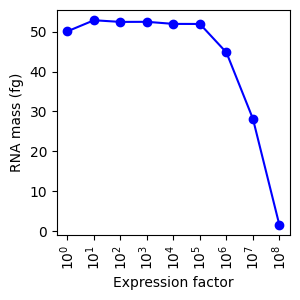

In [12]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(df_gs["expression_level"], df_gs["rnaMass"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("RNA mass (fg)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('rna_mass.png', dpi=300)

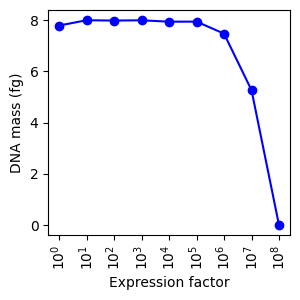

In [13]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(df_gs["expression_level"], df_gs["dnaMass"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("DNA mass (fg)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('dna_mass.png', dpi=300)

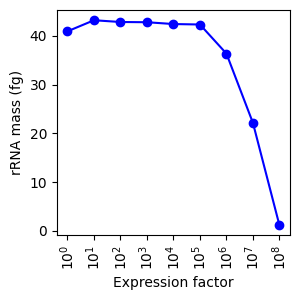

In [14]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(df_gs["expression_level"], df_gs["rRnaMass"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("rRNA mass (fg)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('rrna_mass.png', dpi=300)

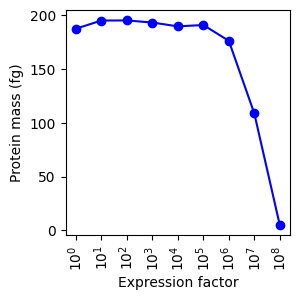

In [15]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(df_gs["expression_level"], df_gs["proteinMass"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("Protein mass (fg)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('protein_mass.png', dpi=300)

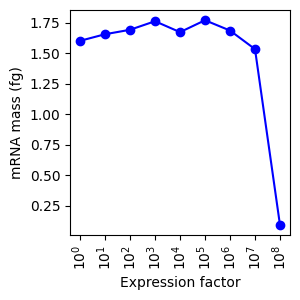

In [16]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(df_gs["expression_level"], df_gs["mRnaMass"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("mRNA mass (fg)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('mrna_mass.png', dpi=300)

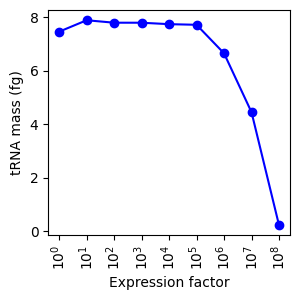

In [17]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(df_gs["expression_level"], df_gs["tRnaMass"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("tRNA mass (fg)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('trna_mass.png', dpi=300)

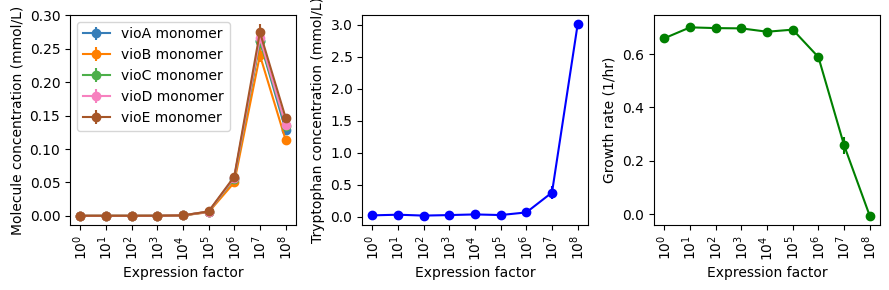

In [18]:
df_gs = dfg.groupby(["expression_level", "tr_efficiency"])[cols]
mapping = {"1":"$10^0$", "10":"$10^1$", "100":"$10^2$", "1000":"$10^3$", "10000":"$10^4$", "100000":"$10^5$", "1000000":"$10^6$", 
           "10000000":"$10^7$", "100000000":"$10^8$", "1000000000":"$10^9$", "10000000000":"$10^10$",}

means = df_gs.mean().reset_index()
counts = df_gs.size().reset_index()
std = df_gs.std().reset_index()
errors = std.copy()
errors[cols] = std[cols] / np.sqrt(counts[0].values[:, np.newaxis])


means["expression_level"] = means["expression_level"].map(mapping)
errors["expression_level"] = errors["expression_level"].map(mapping)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))  # Two subplots
# Plotting for ax1 with error bars for standard deviation
ax1.errorbar(means["expression_level"], means["NG-VioA-MONOMER[c]"], yerr=errors["NG-VioA-MONOMER[c]"], fmt='-o', label='vioA monomer', color='#377eb8')
ax1.errorbar(means["expression_level"], means["NG-VioB-MONOMER[c]"], yerr=errors["NG-VioB-MONOMER[c]"], fmt='-o', label='vioB monomer', color='#ff7f00')
ax1.errorbar(means["expression_level"], means["NG-VioC-MONOMER[c]"], yerr=errors["NG-VioC-MONOMER[c]"], fmt='-o', label='vioC monomer', color='#4daf4a')
ax1.errorbar(means["expression_level"], means["NG-VioD-MONOMER[c]"], yerr=errors["NG-VioD-MONOMER[c]"], fmt='-o', label='vioD monomer', color='#f781bf')
ax1.errorbar(means["expression_level"], means["NG-VioE-MONOMER[c]"], yerr=errors["NG-VioE-MONOMER[c]"], fmt='-o', label='vioE monomer', color='#a65628')
ax1.set_xlabel("Expression factor")
ax1.set_ylabel("Molecule concentration (mmol/L)")
ax1.tick_params(
    axis='x',          
    which='both',      
    rotation=90) 
ax1.legend()

# Plotting for ax2
means[means['expression_level']=='$10^8$']['growth']=0
ax2.errorbar(means["expression_level"], means["TRP[c]"], yerr=errors["TRP[c]"], fmt='-o', color='b')
ax2.set_xlabel("Expression factor")
ax2.set_ylabel("Tryptophan concentration (mmol/L)")
ax2.tick_params(
    axis='x',          
    which='both',      
    rotation=90) 


# Plotting for ax3
means[means['expression_level']=='$10^8$']['growth']=0
ax3.errorbar(means["expression_level"], means["growth"], yerr=errors["growth"], fmt='-o', color='g')
ax3.set_xlabel("Expression factor")
ax3.set_ylabel("Growth rate (1/hr)")
ax3.tick_params(
    axis='x',          
    which='both',      
    rotation=90) 

fig.tight_layout()
fig.savefig('kis_counts.png', dpi=900)  # Save the figure

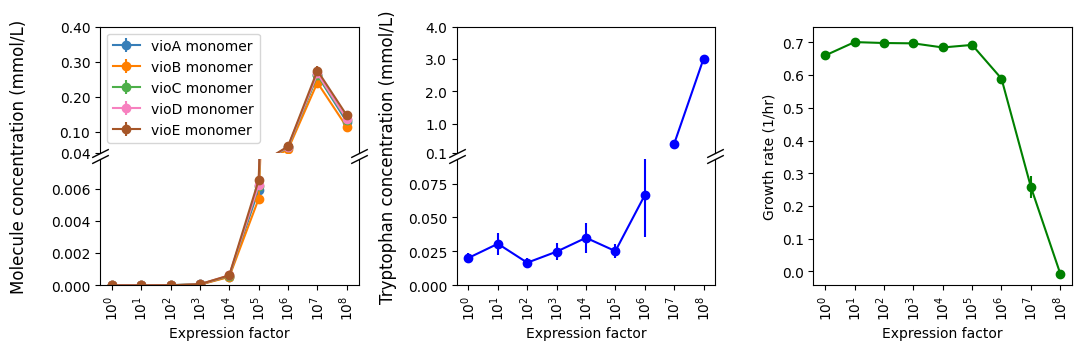

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and grid layout
fig = plt.figure(figsize=(12, 6.8))
gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 1], hspace=0.05, wspace=0.38)

# Create subplots
ax1_top = fig.add_subplot(gs[0, 0])
ax1_bottom = fig.add_subplot(gs[1, 0], sharex=ax1_top)
ax2_top = fig.add_subplot(gs[0, 1])
ax2_bottom = fig.add_subplot(gs[1, 1], sharex=ax2_top)
ax3 = fig.add_subplot(gs[:2, 2])  # spans two rows

# Define break line style (used for both broken axes)
d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

#---------- FIRST PLOT: VIO MONOMERS ----------
# Plot data on both top and bottom axes
for ax in [ax1_top, ax1_bottom]:
    ax.errorbar(means["expression_level"], means["NG-VioA-MONOMER[c]"], yerr=errors["NG-VioA-MONOMER[c]"], fmt='-o', label='vioA monomer', color='#377eb8')
    ax.errorbar(means["expression_level"], means["NG-VioB-MONOMER[c]"], yerr=errors["NG-VioB-MONOMER[c]"], fmt='-o', label='vioB monomer', color='#ff7f00')
    ax.errorbar(means["expression_level"], means["NG-VioC-MONOMER[c]"], yerr=errors["NG-VioC-MONOMER[c]"], fmt='-o', label='vioC monomer', color='#4daf4a')
    ax.errorbar(means["expression_level"], means["NG-VioD-MONOMER[c]"], yerr=errors["NG-VioD-MONOMER[c]"], fmt='-o', label='vioD monomer', color='#f781bf')
    ax.errorbar(means["expression_level"], means["NG-VioE-MONOMER[c]"], yerr=errors["NG-VioE-MONOMER[c]"], fmt='-o', label='vioE monomer', color='#a65628')

# Calculate limits for first plot
first_6_max = max(
    means["NG-VioA-MONOMER[c]"][:6].max(),
    means["NG-VioB-MONOMER[c]"][:6].max(),
    means["NG-VioC-MONOMER[c]"][:6].max(),
    means["NG-VioD-MONOMER[c]"][:6].max(),
    means["NG-VioE-MONOMER[c]"][:6].max()
)

last_6_min = min(
    means["NG-VioA-MONOMER[c]"][6:].min(),
    means["NG-VioB-MONOMER[c]"][6:].min(),
    means["NG-VioC-MONOMER[c]"][6:].min(),
    means["NG-VioD-MONOMER[c]"][6:].min(),
    means["NG-VioE-MONOMER[c]"][6:].min()
)

last_6_max = max(
    means["NG-VioA-MONOMER[c]"][6:].max(),
    means["NG-VioB-MONOMER[c]"][6:].max(),
    means["NG-VioC-MONOMER[c]"][6:].max(),
    means["NG-VioD-MONOMER[c]"][6:].max(),
    means["NG-VioE-MONOMER[c]"][6:].max()
)

# Set y-limits
ax1_top.set_ylim(0.04, last_6_max * 1.2)
ax1_bottom.set_ylim(0, first_6_max * 1.2)

# Add axis break indicator
ax1_top.plot([0, 1], [0, 0], transform=ax1_top.transAxes, **kwargs)
ax1_bottom.plot([0, 1], [1, 1], transform=ax1_bottom.transAxes, **kwargs)

# Configure appearance
ax1_top.spines.bottom.set_visible(False)
ax1_bottom.spines.top.set_visible(False)
ax1_top.tick_params(axis='x', labelbottom=False, bottom=False)  # Remove x-ticks from top plot
ax1_top.legend()

ax1_bottom.set_xlabel("Expression factor")
ax1_bottom.tick_params(axis='x', which='both', rotation=90)

# Add specific break point tick
current_yticks = ax1_top.get_yticks()
if 0.04 not in current_yticks:
    new_yticks = np.append([0.04], current_yticks[current_yticks > 0.04])
    ax1_top.set_yticks(new_yticks)

#---------- SECOND PLOT: TRYPTOPHAN ----------
ax2_bottom.errorbar(means["expression_level"][:7], means["TRP[c]"][:7], yerr=errors["TRP[c]"][:7], fmt='-o', color='b')

# Plot in top subplot - values after index 7
ax2_top.errorbar(means["expression_level"][7:], means["TRP[c]"][7:], yerr=errors["TRP[c]"][7:], fmt='-o', color='b')

# Calculate appropriate limits for the break
first_7_max = means["TRP[c]"][:7].max()  # Maximum value through index 6
last_values_min = means["TRP[c]"][7:].min()  # Minimum of remaining values
last_values_max = means["TRP[c]"][7:].max()  # Maximum of remaining values

# Choose a break value between the ranges
trp_break_value = (first_7_max + last_values_min) / 2
# Ensure it's a round value for better readability
trp_break_value = 0.1  # You can adjust this as needed

# Set y-limits for both subplots with a clear separation
ax2_top.set_ylim(trp_break_value, last_values_max * 1.1)  # Top plot for higher values
ax2_bottom.set_ylim(0, first_7_max * 1.4)  # Bottom plot for lower values

# Add axis break indicator
ax2_top.plot([0, 1], [0, 0], transform=ax2_top.transAxes, **kwargs)
ax2_bottom.plot([0, 1], [1, 1], transform=ax2_bottom.transAxes, **kwargs)

# Configure appearance
ax2_top.spines.bottom.set_visible(False)
ax2_bottom.spines.top.set_visible(False)
ax2_top.tick_params(axis='x', labelbottom=False, bottom=False)  # Remove x-ticks from top plot

ax2_bottom.set_xlabel("Expression factor")
ax2_bottom.tick_params(axis='x', which='both', rotation=90)

# Add specific break point tick for the top plot
current_yticks_ax2 = ax2_top.get_yticks()
if trp_break_value not in current_yticks_ax2:
    new_yticks_ax2 = np.append([trp_break_value], current_yticks_ax2[current_yticks_ax2 > trp_break_value])
    ax2_top.set_yticks(new_yticks_ax2)


#---------- THIRD PLOT: GROWTH RATE ----------
# Fix data
means[means['expression_level']=='$10^8$']['growth'] = 0

# Plot data
ax3.errorbar(means["expression_level"], means["growth"], yerr=errors["growth"], fmt='-o', color='g')

# Configure appearance
ax3.set_xlabel("Expression factor")
ax3.set_ylabel("Growth rate (1/hr)")
ax3.tick_params(axis='x', which='both', rotation=90)

# Layout adjustments
plt.tight_layout()
plt.subplots_adjust(left=0.09, wspace=0.4, hspace=0.2)

# Use fig.text for more precise control of y-label positioning
# Calculate center positions for the broken axes
y_center1 = (ax1_top.get_position().y1 + ax1_bottom.get_position().y0) / 2
y_center2 = (ax2_top.get_position().y1 + ax2_bottom.get_position().y0) / 2

# Add y-axis labels with precise positioning
fig.text(0.015, y_center1, "Molecule concentration (mmol/L)", va='center', rotation='vertical', fontsize=12)
fig.text(ax2_bottom.get_position().x0 - 0.065, y_center2, "Tryptophan concentration (mmol/L)", 
         va='center', rotation='vertical', fontsize=12)

# Save figure
fig.savefig('kis_counts.png', dpi=900)

## Statistical analysis

In [20]:
cols = df.drop(columns=['generation', 'expression_level', 'tr_efficiency', 'seed', 'dnaMass',
       'mRnaMass', 'rnaMass', 'rRnaMass', 'tRnaMass', 'proteinMass', 'cell_path', 'cell_mass', 
       'cell_volume', 'growth', 'time', 'variant', "NG-VioA-MONOMER[c]", "NG-VioB-MONOMER[c]", 
                        "NG-VioC-MONOMER[c]", "NG-VioD-MONOMER[c]", "NG-VioE-MONOMER[c]"]).columns


In [21]:
set(df['generation'])

{'generation_000011',
 'generation_000012',
 'generation_000013',
 'generation_000014',
 'generation_000015',
 'generation_000016',
 'generation_000017',
 'generation_000018',
 'generation_000019'}

In [22]:
import pandas as pd
import numpy as np
from scipy.stats import levene, shapiro, mannwhitneyu, ttest_ind

dfg = df.drop(columns=["cell_path", "time", "variant", "generation"]).groupby(["expression_level", "tr_efficiency", "seed"])[cols].mean().reset_index()

df_control = dfg[dfg['expression_level']=='1000000'][cols]
dfg = dfg[dfg['expression_level']=='10000000'][cols]


# Remove constant columns from both datasets
constant_columns_wt = list(df_control.columns[(df_control.mean() == 0) & (df_control.std() == 0)])
constant_columns_m = list(dfg.columns[(dfg.mean() == 0) & (dfg.std() == 0)])

constant_columns = list(set(constant_columns_wt) & set(constant_columns_m))
df_control = df_control.drop(columns=constant_columns+[ 'RPOE-MONOMER[c]'], errors='ignore')
dfg = dfg.drop(columns=constant_columns+[ 'RPOE-MONOMER[c]'], errors='ignore')
print(len(dfg), len(df_control), len(df_control.columns))

# Setup
significance_threshold = 0.0005
log2_fc_threshold = np.log2(1.5)  # Equivalent to 1.5x fold change

results = {}
significant_parametric = []
significant_non_parametric = []
norm = []

for col in df_control.columns:
    data_control = df_control[col].dropna()
    data_dfg = dfg[col].dropna()

    mean_control = data_control.mean()
    mean_dfg = data_dfg.mean()
    
    if mean_control == 0:
        log2_fc = np.inf if mean_dfg > 0 else -np.inf
    else:
        log2_fc = np.log2(mean_dfg / mean_control) if mean_dfg > 0 else -np.inf

    # Normality tests
    stat_wt, p_wt = shapiro(data_control)
    stat_mut, p_mut = shapiro(data_dfg)

    if p_wt > 0.05 and p_mut > 0.05:
        norm.append(col)
        stat_lev, p_lev = levene(data_control, data_dfg)
        use_pooled = p_lev > 0.05

        _, p = standardize_mean_differences(data_control, data_dfg, use_pooled=use_pooled)

        if p <= significance_threshold and abs(log2_fc) >= log2_fc_threshold:
            significant_parametric.append((col, p, log2_fc))
    else:
        stat, p = mannwhitneyu(data_control, data_dfg, alternative='two-sided')
        if p < significance_threshold and abs(log2_fc) >= log2_fc_threshold:
            significant_non_parametric.append((col, p, log2_fc))
        results[col] = {'Mann-Whitney Statistic': stat, 'P-Value': p, 'log2FC': log2_fc}



17 19 5604


In [23]:
print(len(significant_parametric), len(significant_non_parametric))

1730 695


In [24]:
significant_non_parametric = [col for col, *_ in significant_non_parametric]
significant_parametric = [col for col, *_ in significant_parametric]
significant_parametric_no_meta = significant_parametric
significant_non_parametric_no_meta = significant_non_parametric

In [25]:
increase = []
# Analyze and print the direction of changes for parametric significant molecules
direction_parametric = compare_concentrations(df_control, dfg, significant_parametric)
for k,v in direction_parametric.items():
    if v=='Increase':
        increase.append(k)

# Analyze and print the direction of changes for non-parametric significant molecules
direction_non_parametric = compare_concentrations(df_control, dfg, significant_non_parametric)
for k,v in direction_non_parametric.items():
    if v=='Increase':
       increase.append(k)

In [26]:
df_significant = pd.DataFrame(columns=['Molecule name', 'Parametric', 'Non-parametric', 'Increasing/decreasing', 'Gene'])
df_significant['Molecule name'] = significant_parametric + significant_non_parametric
df_significant['Parametric'] = [True if x in significant_parametric else False for x in list(df_significant['Molecule name'])]
df_significant['Non-parametric'] = [True if x in significant_non_parametric else False for x in list(df_significant['Molecule name'])]
df_significant['Increasing/decreasing'] = ['Increasing' if x in increase else 'Decreasing' for x in list(df_significant['Molecule name'])]

In [27]:
df_significant['Molecule name no loc'] = df_significant['Molecule name'].str.split('[').str[0]

In [28]:
print(len(significant_non_parametric), len(significant_parametric), len(increase))

695 1730 15


In [29]:
file_path = "genes_ecocyc.txt"  
df_eco = pd.read_csv(file_path, sep="\t")  

df_eco['Product'] = df_eco['Product'].str.split(' // ')

df_eco = df_eco.explode('Product')

### Analysis on molecules decreasing

In [30]:
import re
monomers = []
complex = []
others = []
rna = []
peptide = []


for x in set(significant_non_parametric + significant_parametric) - set(increase):
    if x.endswith('MER[c]') or x.startswith('PROTEIN') or x.startswith('PHOSPHO')   or x.startswith('PC') or x.endswith('PROTEIN') or x.endswith('PROTEIN[j]') or x.endswith('PROTEIN[o]') or x.endswith('MER[l]') or x.endswith('MER[j]') or x.startswith('MONOMER') or x.endswith('MER[o]') or x.endswith('MER[e]') or x.endswith('MER[m]') or x.endswith('MER[p]') or x.endswith('MER[i]'):
        monomers.append(remove_brackets(x))
    elif x.endswith('CPLX[c]') or x.endswith('-CPLX[p]') or x.endswith('CPLX[m]') or x.endswith('CPLX[i]') or x.endswith('CPLX[o]') or x.startswith('CPLX'):
        complex.append(remove_brackets(x))
    elif x.endswith('RRNA[c]') or x.endswith('RRNA[i]') or x.endswith('tRNA[c]') or x.startswith('RNA'):
        rna.append(remove_brackets(x))
    elif x.startswith('PD'):
        peptide.append(remove_brackets(x))
    else:
        others.append(remove_brackets(x))
        

In [31]:
decreasing = set(significant_non_parametric + significant_parametric) - set(increase)

In [32]:
print(len(monomers), len(complex), len(others), len(rna), len(peptide))

1662 633 36 49 30


In [33]:
print(len(monomers))
df_mon = df_eco[(df_eco['Product'].isin(monomers)) | 
                (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(monomers))]


1662


In [34]:
# Rename based on Ecocyc
mono_dict = {'ASPCARBREG-DIMER': 'pyrI',
 'GLUTAMINESYN-OLIGOMER': 'glnA',
 'MONOMER0-160': 'dnaA',
 'MONOMER0-4565': 'dnaA' ,
 'PC00003': 'araC',
 'PC00004': 'crp',
 'PC00005': 'argR',
 'PC00007': 'trpR',
 'PC00033': 'purR',
 'PC00040': 'cysB',
 'PC00061': 'cra',
 'PC00086': 'rhaS',
 'PHOSPHO-BASS-FE+3-CPLX': '', 
 'MONOMER0-163': 'tyrR', 
 'MONOMER-2720': 'cbl',
 'MONOMER-51': 'fadR',
 'MONOMER-55': 'gntR',
 'PC00010': 'lexA', 'PC00027':'', 'MONOMER0-155':'lrp'}

In [35]:
for k in set(monomers) - set(df_mon['Product']) - set(df_mon['Gene products (complexes, polypeptides, and RNAs)']):
    if k in mono_dict.keys():
        temp_df = df_eco[df_eco['Common-Name'] == mono_dict[k]].copy()
        temp_df['Product'] = k
        df_mon = pd.concat([df_mon, temp_df])
    else:
        print(k)

In [36]:
complex = list(set(complex) - set([remove_brackets(x) for x in increase]))
print(len(complex))
df_com = df_eco[df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(complex)]


633


In [37]:
set(complex) - set(df_com['Gene products (complexes, polypeptides, and RNAs)']) -  set(df_com['Gene products (complexes, polypeptides, and RNAs)'])

{'ACETYL-COA-CARBOXYLTRANSFER-CPLX',
 'ACSERLYA-CPLX',
 'ALAS-CPLX',
 'APORNAP-CPLX',
 'ARCB-CPLX',
 'ATPA-CPLX',
 'ATPD-CPLX',
 'ATPE-CPLX',
 'ATPF-CPLX',
 'BASS-FE+3-CPLX',
 'BIOTIN-CARBOXYL-CPLX',
 'CPLX-157',
 'CPLX0-10427',
 'CPLX0-1161',
 'CPLX0-1321',
 'CPLX0-226',
 'CPLX0-2361',
 'CPLX0-2541',
 'CPLX0-3',
 'CPLX0-3102',
 'CPLX0-3104',
 'CPLX0-3107',
 'CPLX0-3108',
 'CPLX0-3461',
 'CPLX0-3521',
 'CPLX0-3541',
 'CPLX0-3621',
 'CPLX0-3781',
 'CPLX0-3956',
 'CPLX0-3962',
 'CPLX0-7418',
 'CPLX0-7605',
 'CPLX0-7608',
 'CPLX0-7628',
 'CPLX0-7666',
 'CPLX0-7669',
 'CPLX0-7670',
 'CPLX0-7710',
 'CPLX0-7733',
 'CPLX0-7740',
 'CPLX0-7756',
 'CPLX0-7759',
 'CPLX0-7796',
 'CPLX0-7796APO',
 'CPLX0-7823',
 'CPLX0-7854',
 'CPLX0-7910',
 'CPLX0-7921',
 'CPLX0-7929',
 'CPLX0-7942',
 'CPLX0-7956',
 'CPLX0-7964',
 'CPLX0-7998',
 'CPLX0-8102',
 'CPLX0-8103',
 'CPLX0-8196',
 'CPLX0-8218',
 'CPLX0-8234',
 'CPLX0-8256',
 'CPLX0-8285',
 'CPLX0-841',
 'CPLX0-8578',
 'CPLX0-8593',
 'CPLX0-8597',
 'CPLX0-

In [38]:
# Rename based on Ecocyc
dict_complex = {'ACETYL-COA-CARBOXYLTRANSFER-CPLX':'',
 'ACSERLYA-CPLX': 'cysK',
 'ALAS-CPLX': 'alaS',
 'APORNAP-CPLX': '',
 'ARCB-CPLX': 'arcB',
 'ARCB-OXYGEN-CPLX': '',
 'ATOD-CPLX': 'atoD',
 'ATPA-CPLX': 'atpA',
 'ATPD-CPLX': 'atpD',
 'ATPE-CPLX': 'atpE',
 'ATPF-CPLX': 'atpF',
 'BASS-FE+3-CPLX': '',
 'BIOTIN-CARBOXYL-CPLX': 'accC',
 'CPLX-157': '',
 'CPLX0-0': 'dnaT',
 'CPLX0-10427': 'ptrR',
 'CPLX0-1161': 'hslU',
 'CPLX0-1321': '',
 'CPLX0-226': 'crp',
 'CPLX0-2361': '',
 'CPLX0-2541': 'modE',
 'CPLX0-3': '',
 'CPLX0-3102': 'clpX',
 'CPLX0-3104':'',
 'CPLX0-3107':'',
 'CPLX0-3108':'',
 'CPLX0-3461':'rne',
 'CPLX0-3521':'pnp',
 'CPLX0-3541':'rhlB',
 'CPLX0-3621': 'dnaB',
 'CPLX0-3781': '',
 'CPLX0-3953': '',
 'CPLX0-3956': '',
 'CPLX0-3962': '',
 'CPLX0-7418': 'mprA',
 'CPLX0-7605': 'iclR',
 'CPLX0-7608': 'mnmE',
 'CPLX0-7628': '',
 'CPLX0-7666': 'caiF',
 'CPLX0-7669': 'argP',
 'CPLX0-7670': 'argP',
 'CPLX0-7679': 'zur',
 'CPLX0-7710': 'marR',
 'CPLX0-7733': 'asnC',
 'CPLX0-7740': 'cytR',
 'CPLX0-7745': 'murR',
 'CPLX0-7756': 'csrA',
 'CPLX0-7759': 'metR',
 'CPLX0-7796': 'metJ',
 'CPLX0-7796APO': '',
 'CPLX0-7823': '',
 'CPLX0-7854': 'treR',
 'CPLX0-7910': '',
 'CPLX0-7921': 'manX',
 'CPLX0-7928': 'relB',
 'CPLX0-7929': 'yefM',
 'CPLX0-7942': '',
 'CPLX0-7956': 'csrA',
 'CPLX0-7964': 'tolC',
 'CPLX0-7998': 'rapZ',
 'CPLX0-8095': 'rnlA',
 'CPLX0-8102': 'tar',
 'CPLX0-8103': 'tsr',
 'CPLX0-8104': 'tap',
 'CPLX0-8105': 'trg',
 'CPLX0-8196': 'minC',
 'CPLX0-8206': 'dhaM',
 'CPLX0-8218': 'dosC',
 'CPLX0-8234': 'frmR',
 'CPLX0-8256': 'hupA',
 'CPLX0-8285': 'ompR',
 'CPLX0-8288': 'cusS',
 'CPLX0-8302': 'barA',
 'CPLX0-8309': 'pyrR',
 'CPLX0-8311': 'yoeB',
 'CPLX0-841': 'mazE',
 'CPLX0-8576': 'frlR',
 'CPLX0-8578': 'dgoR',
 'CPLX0-8593': 'nanR',
 'CPLX0-8597': 'rcdA',
 'CPLX0-881': 'clpA',
 'CPLX0-9318': 'ptrR',
 'E3-CPLX': 'lpd',
 'ENOLASE-CPLX': 'eno',
 'ENTE-CPLX': 'entE',
 'F-O-CPLX': '',
 'GCVP-CPLX': 'gcvP',
 'NRDF-CPLX': 'nrdF',
 'PHOQ-CA+2-CPLX': '',
 'PIIPROTEIN-CPLX': 'glnB',
 'SECE-G-Y-CPLX': '', 
 'CPLX0-8595': 'chbR',
 'CPLX0-7731': 'paaX', 
 'CPLX0-7696': 'mukB',
 'CPLX0-8314': 'evgS',
 'CPLX0-10308': 'phnL',
 'CPLX0-7713': 'dsdC',
 'TORS-CPLX': 'torS',
 'CPLX0-7817': 'grxD',
 'CPLX-9493': '',
 'E1P-CPLX': 'aceE',
 'CPLX0-3561': 'hypB',
 'PII2-CPLX': 'glnK',
 'B1-CPLX': 'nrdA'}

In [39]:
for k in set(complex) - set(df_com['Gene products (complexes, polypeptides, and RNAs)']) -  set(df_com['Gene products (complexes, polypeptides, and RNAs)']):
    if k in dict_complex.keys():
        temp_df = df_eco[df_eco['Common-Name'] == dict_complex[k]].copy()
        temp_df['Gene products (complexes, polypeptides, and RNAs)'] = k
        df_com = pd.concat([df_com, temp_df])

        if dict_complex[k]=='':
            print('No gene for ', k)
    else:
        print(k)

No gene for  CPLX0-7942
No gene for  CPLX-157
No gene for  CPLX0-7910
No gene for  CPLX0-7823
No gene for  ACETYL-COA-CARBOXYLTRANSFER-CPLX
No gene for  CPLX0-1321
No gene for  PHOQ-CA+2-CPLX
No gene for  CPLX0-3107
No gene for  CPLX0-7628
No gene for  CPLX0-3781
No gene for  F-O-CPLX
No gene for  CPLX0-3956
No gene for  CPLX0-3
No gene for  BASS-FE+3-CPLX
No gene for  APORNAP-CPLX
No gene for  CPLX0-3962
No gene for  CPLX0-2361
No gene for  CPLX0-7796APO
No gene for  SECE-G-Y-CPLX
No gene for  CPLX0-3104
No gene for  CPLX0-3108


In [40]:
# For peptides we do gene ontology analysis
peptide = list(set(peptide) - set([remove_brackets(x) for x in increase]))
df_pep = df_eco[(df_eco['Product'].isin(peptide)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(peptide))]


In [41]:
set(peptide) - set(df_pep['Product']) - set(df_pep['Gene products (complexes, polypeptides, and RNAs)'])

set()

In [42]:
# For rnas we do gene ontology analysis
rna = list(set(rna) - set([remove_brackets(x) for x in increase]))
df_rna = df_eco[(df_eco['Product'].isin(rna)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(rna))]


In [43]:
set(rna) - set(df_rna['Product']) - set(df_rna['Gene products (complexes, polypeptides, and RNAs)'])


set()

In [44]:
df_rna = pd.concat([df_rna, df_eco[(df_eco['Common-Name']=='metY')]])

In [45]:
others = list(set(others)  - set([remove_brackets(x) for x in increase]))
df_others = df_eco[(df_eco['Product'].isin(others)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(others))]


In [46]:
print(len(set(others) - set(df_others['Product']) - set(df_others['Gene products (complexes, polypeptides, and RNAs)'])))
set(others) - set(df_others['Product']) - set(df_others['Gene products (complexes, polypeptides, and RNAs)'])

3


{'CPD-9956', 'E2O', 'FLAGELLAR-MOTOR-COMPLEX'}

In [47]:
df_com_mon = pd.concat([df_mon, df_rna, df_others, df_com, df_pep])

In [48]:
temp_gene_products = df_com_mon[['Gene products (complexes, polypeptides, and RNAs)', 'Common-Name']]
temp_gene_products.rename(columns={'Gene products (complexes, polypeptides, and RNAs)': 'match_key'}, inplace=True)

temp_product = df_com_mon[['Product', 'Common-Name']]
temp_product.rename(columns={'Product': 'match_key'}, inplace=True)

match_df = pd.concat([temp_gene_products, temp_product])
match_df.drop_duplicates(subset=['match_key'], inplace=True)

df_significant = df_significant.merge(
    match_df,
    left_on='Molecule name no loc',
    right_on='match_key',
    how='left'
)

df_significant['Gene'] = df_significant['Common-Name']
df_significant.drop(columns=['match_key', 'Common-Name'], inplace=True)



#### Create GO plots and analysis

In [49]:
df_com_mon['Common-Name']

5       aaeR
6       aaeX
8        aat
13      abpA
17      accB
        ... 
2573     rob
2722    rutR
2770    sdiA
2853    soxS
2876    srlR
Name: Common-Name, Length: 2614, dtype: object

In [50]:
genes = [x if x not in ['dicD', 'hipH',   'pqqU',  'trhA',  'lptM'] else df_com_mon[df_com_mon['Common-Name']==x]['Synonyms'].str.split(' // ').str[0].values[0] for x in list(df_com_mon['Common-Name'])]
genes1 = [x if x not in ['insAB1', 'insAB6', 'insCD1', 'insCD2', 'insCD5', 'insCD6', 'insEF1', 'insEF2', 'insAB1', 'insAB6', 'insCD1', 
                         'insCD2', 'insCD5', 'insCD6', 'insEF1', 'insEF2']  else x[:-1]+'-'+x[-1] for x in genes]

In [51]:
genes = list(df_com_mon['Common-Name'])
len(set(genes))

2386

In [52]:
df_go = go_it(set(genes))
df_go['per'] = df_go.n_genes/df_go.n_go

input genes: 2386
dicD
hipH
insAB6
lptM
insCD6
insAB1
insEF2
ptrR
insAB3
trhA
insCD1
mapped genes: 2375

Runing BP Ontology Analysis: current study set of 2375 IDs.
 80%  1,895 of  2,375 study items found in association
100%  2,375 of  2,375 study items found in population(4640)
Calculating 1,760 uncorrected p-values using fisher_scipy_stats
   1,760 terms are associated with  3,298 of  4,640 population items
   1,405 terms are associated with  1,895 of  2,375 study items
  METHOD fdr_bh:
      48 GO terms found significant (< 0.05=alpha) ( 37 enriched +  11 purified): statsmodels fdr_bh
     656 study items associated with significant GO IDs (enriched)
     183 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 2375 IDs.
 76%  1,811 of  2,375 study items found in association
100%  2,375 of  2,375 study items found in population(4640)
Calculating 261 uncorrected p-values using fisher_scipy_stats
     261 terms are associated wit

In [53]:
df = df_go.drop(columns=['p_corr', 'n_genes', 'n_study']).sort_values('per', ascending=False).copy()


In [54]:
# Generate a LaTeX file with sections instead of a table
with open('go_terms_sections.tex', 'w') as f:
    f.write(r'\section*{GO Term Analysis}' + '\n\n')
    
    for _, row in df.iterrows():
        f.write(f"\\subsection*{{GO:{row['GO']} - {row['term']}}}\n")
        f.write(f"\\textbf{{Class:}} {row['class']}\\\\n")
        f.write(f"\\textbf{{p-value:}} {row['p']}\\\\n")
        f.write(f"\\textbf{{Number of GO terms:}} {row['n_go']}\\\\n")
        f.write(f"\\textbf{{Percentage:}} {row['per']}\\\\n")
        f.write(f"\\textbf{{Genes:}}\n\\small\\raggedright\n{row['study_genes']}\n\n")
        f.write(r'\vspace{1em}' + '\n')

In [55]:
df_go.sort_values(['per', 'n_go'], ascending=[False, False]).to_csv('df_go_burden_00005.csv')

In [56]:
len(df_go.sort_values(['per', 'n_go'], ascending=[False, False])[df_go['per']>0.9])

37

In [57]:
from goatools.gosubdag.gosubdag import GoSubDag

significant_terms = list(df_go[df_go['per']>0.9]['GO'])
# Create a subset graph for the significant terms
gosubdag = GoSubDag(significant_terms, obodag, prt=None)


# Use the function to filter terms
most_general_terms = find_most_general_terms(significant_terms, gosubdag)

print("Most general terms to plot:", most_general_terms)
len(most_general_terms)
len(significant_terms)

Most general terms to plot: {'GO:0009425', 'GO:0006935', 'GO:0120102', 'GO:0006400', 'GO:0016226', 'GO:0009288', 'GO:0097588', 'GO:0006364', 'GO:0090529', 'GO:0042254', 'GO:0006412', 'GO:1990228', 'GO:0006221', 'GO:0045454', 'GO:0005840', 'GO:0044781', 'GO:0030257', 'GO:0098869', 'GO:0006826', 'GO:1990904', 'GO:0000049', 'GO:0003735', 'GO:0017148', 'GO:0098797', 'GO:0034599', 'GO:0043022', 'GO:0006164', 'GO:0006418', 'GO:0000028', 'GO:0009229'}


37

In [58]:
df_go_gen = df_go[df_go['GO'].isin(most_general_terms)]
df_go_gen.sort_values(['per', 'n_go'], ascending=[False, False]).to_csv('df_go_burden_less_00005.csv')
data = df_go_gen[['GO', 'term', 'p', 'study_genes']]

# Convert p-values to negative log scale for better visualization
data['neg_log_p'] = -np.log10(data['p'])

# Create similarity matrix
similarity_matrix = np.zeros((len(data), len(data)))

for i in range(len(data)):
    for j in range(len(data)):
        similarity_matrix[i, j] = jaccard_similarity(data.iloc[i]['study_genes'], data.iloc[j]['study_genes'])

# Convert similarity to distance
distance_matrix = 1 - similarity_matrix

# Hierarchical clustering
linked = linkage(squareform(distance_matrix), method='complete')



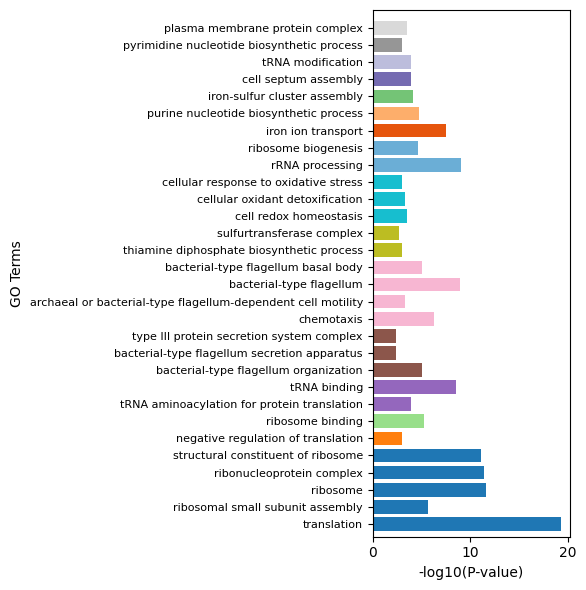

In [59]:
from matplotlib import cm, colors
# Assign clusters at a specified cut-off value
t = 0.9  # This threshold can be adjusted
clusters = fcluster(linked, t, criterion='distance')
data['cluster'] = clusters

# Plotting the clustered GO terms with color coding
plt.figure(figsize=(6, 6))
unique_clusters = np.unique(clusters)

colors=colors.ListedColormap(cm.tab20.colors + cm.tab20c.colors, name='tab40')(np.linspace(0, 1, len(unique_clusters)))
for cluster, color in zip(unique_clusters, colors):
    clustered_data = data[(data['cluster'] == cluster)]
    plt.barh(clustered_data['term'], -np.log10(clustered_data['p']), color=color)

plt.xlabel('-log10(P-value)')
plt.ylabel('GO Terms')
plt.gca().invert_yaxis()
plt.ylim(-0.75, len(data)+0.05)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('go_KO_no_meta_00005.png', dpi=500)


In [60]:
missing = ['RNA catabolic process', 'guanosine tetraphosphate binding', 'fatty acid biosynthetic process',
           'response to copper ion', 'nucleoid']

In [61]:
df_go[df_go['term'].isin(missing)]

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes,per
25,GO:0006633,fatty acid biosynthetic process,biological_process,0.000419,0.021701,18,2375,20,"[fabA, fabY, acpP, fabD, fabF, cfa, accD, fabG...",0.900000
79,GO:0097216,guanosine tetraphosphate binding,molecular_function,0.000004,0.000737,31,2375,35,"[speC, tufB, fusA, purC, mpl, bipA, gsk, ppx, ...",0.885714


In [62]:
data.sort_values('cluster').to_csv('df_go_burden_cluster_new_00005.csv')

### Analysis on molecules increasing

In [63]:
monomers_increase = []
complex_increase = []
others_increase = []
rna_increase = []
peptide_increase = []

for x in set(increase):
    if x.endswith('MER[c]') or x.startswith('PROTEIN') or x.startswith('PHOSPHO')   or x.startswith('PC') or x.endswith('PROTEIN') or x.endswith('PROTEIN[j]') or x.endswith('PROTEIN[o]') or x.endswith('MER[l]') or x.endswith('MER[j]') or x.startswith('MONOMER') or x.endswith('MER[o]') or x.endswith('MER[e]') or x.endswith('MER[m]') or x.endswith('MER[p]') or x.endswith('MER[i]'):
        monomers_increase.append(remove_brackets(x))
    elif x.endswith('CPLX[c]') or x.endswith('-CPLX[p]') or x.endswith('CPLX[m]') or x.endswith('CPLX[i]') or x.endswith('CPLX[o]') or x.startswith('CPLX'):
        complex_increase.append(remove_brackets(x))
    elif x.endswith('RRNA[c]') or x.endswith('RRNA[i]') or x.endswith('tRNA[c]') or x.startswith('RNA'):
        rna_increase.append(remove_brackets(x))
    elif x.startswith('PD'):
        peptide_increase.append(remove_brackets(x))
    else:
        others_increase.append(remove_brackets(x))

In [64]:
len(increase)

15

In [65]:
print(len(monomers_increase), len(complex_increase), len(others_increase), len(rna_increase), len(peptide_increase))

2 0 9 4 0


In [66]:
monomers_increase

['GLUSYNLARGE-MONOMER', 'UPPSYN-MONOMER']

In [67]:
rna_increase

['cysT-tRNA', 'RRSA-RRNA', 'RRLA-RRNA', 'RRFA-RRNA']

In [68]:
others_increase

['LYS',
 'VAL',
 'polymerized_GTP',
 'polymerized_CTP',
 'ILE',
 'ASN',
 'HIS',
 'LEU',
 'THR']

In [69]:
df_mon_increase = df_eco[(df_eco['Product'].isin(monomers_increase)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(monomers_increase))]
set(monomers_increase) - set(df_mon_increase['Product']) - set(df_mon_increase['Gene products (complexes, polypeptides, and RNAs)'])

set()

In [70]:
df_com_increase = df_eco[df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(complex_increase)]
set(complex_increase) - set(df_com_increase['Product']) - set(df_com_increase['Gene products (complexes, polypeptides, and RNAs)'])

set()

In [71]:
df_rna_increase = df_eco[(df_eco['Product'].isin(rna_increase)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(rna_increase))]
set(rna_increase) - set(df_rna_increase['Product']) - set(df_rna_increase['Gene products (complexes, polypeptides, and RNAs)'])

set()

In [72]:
df_peptide_increase = df_eco[(df_eco['Product'].isin(peptide_increase)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(peptide_increase))]
set(peptide_increase) - set(df_peptide_increase['Product']) - set(df_peptide_increase['Gene products (complexes, polypeptides, and RNAs)'])

set()

In [73]:
df_increase = pd.concat([df_mon_increase, df_com_increase, df_rna_increase, df_peptide_increase])

In [74]:
temp_gene_products1 = df_increase[['Gene products (complexes, polypeptides, and RNAs)', 'Common-Name']]
temp_gene_products1.rename(columns={'Gene products (complexes, polypeptides, and RNAs)': 'match_key'}, inplace=True)

temp_product1 = df_increase[['Product', 'Common-Name']]
temp_product1.rename(columns={'Product': 'match_key'}, inplace=True)

temp_gene_products2 = df_com_mon[['Gene products (complexes, polypeptides, and RNAs)', 'Common-Name']]
temp_gene_products2.rename(columns={'Gene products (complexes, polypeptides, and RNAs)': 'match_key'}, inplace=True)

temp_product2 = df_com_mon[['Product', 'Common-Name']]
temp_product2.rename(columns={'Product': 'match_key'}, inplace=True)

match_df = pd.concat([temp_gene_products1, temp_product1, temp_gene_products2, temp_product2])
match_df.drop_duplicates(subset=['match_key'], inplace=True)

df_significant = df_significant.merge(
    match_df,
    left_on='Molecule name no loc',
    right_on='match_key',
    how='left'
)

df_significant['Gene'] = df_significant['Common-Name']
df_significant.drop(columns=['match_key', 'Common-Name'], inplace=True)

df_significant[df_significant['Gene'].isna()]

,Molecule name,Parametric,Non-parametric,Increasing/decreasing,Gene,Molecule name no loc
33,ACETYL-COA-CARBOXYLTRANSFER-CPLX[c],True,False,Decreasing,NaN,ACETYL-COA-CARBOXYLTRANSFER-CPLX
121,CPLX-157[i],True,False,Decreasing,NaN,CPLX-157
138,CPLX0-1321[m],True,False,Decreasing,NaN,CPLX0-1321
157,CPLX0-2361[c],True,False,Decreasing,NaN,CPLX0-2361
177,CPLX0-3[c],True,False,Decreasing,NaN,CPLX0-3
184,CPLX0-3104[c],True,False,Decreasing,NaN,CPLX0-3104
185,CPLX0-3107[c],True,False,Decreasing,NaN,CPLX0-3107
186,CPLX0-3108[c],True,False,Decreasing,NaN,CPLX0-3108
220,CPLX0-3956[c],True,False,Decreasing,NaN,CPLX0-3956
223,CPLX0-3962[c],True,False,Decreasing,NaN,CPLX0-3962


In [75]:
len(df_significant)

2425

In [76]:
df_significant.to_csv('significant_no_meta.csv')

In [77]:
increase

['polymerized_CTP[c]',
 'polymerized_GTP[c]',
 'ASN[c]',
 'GLUSYNLARGE-MONOMER[c]',
 'HIS[c]',
 'ILE[c]',
 'LEU[c]',
 'LYS[c]',
 'RRFA-RRNA[c]',
 'RRLA-RRNA[c]',
 'RRSA-RRNA[c]',
 'THR[c]',
 'UPPSYN-MONOMER[c]',
 'VAL[c]',
 'cysT-tRNA[c]']

In [78]:
df_increase

,All-Genes,Accession-1,Accession-2,Synonyms,"Gene products (complexes, polypeptides, and RNAs)",Common-Name,Object ID,Accession-2.1,Names,Product,GO terms (biological process),GO terms (cellular component),GO terms (molecular function)
1128,EG10403,b3212,ECK3202,psiQ // ossB // aspB,GLUTAMATESYN-CPLX,gltB,EG10403,ECK3202,gltB // psiQ // ossB // aspB // b3212 // ECK3202,GLUSYNLARGE-MONOMER,GO:0019676 // GO:0097054 // GO:0006541 // GO:0...,GO:0009342 // GO:0005829,GO:0016491 // GO:0015930 // GO:0051538 // GO:0...
1529,G6092,b0174,ECK0173,uppS // rth // yaeS,UPPSYN-CPLX,ispU,G6092,ECK0173,ispU // uppS // rth // yaeS // b0174 // ECK0173,UPPSYN-MONOMER,GO:0071555 // GO:0051301 // GO:0008360 // GO:0...,GO:0005829 // GO:0005737,GO:0045547 // GO:0036094 // GO:0046872 // GO:0...
556,G7991,b1910,ECK1909,NaN,cysT-tRNA,cysT,G7991,ECK1909,cysT // b1910 // ECK1909,cysT-tRNA,NaN,GO:0005829 // GO:0005737,GO:0030533
2653,EG30070,b3855,ECK3847,NaN,CPLX0-3964,rrfA,EG30070,ECK3847,rrfA // b3855 // ECK3847,RRFA-RRNA,NaN,NaN,NaN
2661,EG30077,b3854,ECK3846,NaN,CPLX0-3964,rrlA,EG30077,ECK3846,rrlA // b3854 // ECK3846,RRLA-RRNA,NaN,NaN,NaN
2670,EG30084,b3851,ECK3843,NaN,CPLX0-3964,rrsA,EG30084,ECK3843,rrsA // b3851 // ECK3843,RRSA-RRNA,NaN,NaN,NaN


In [79]:
genes_increase = list(df_increase['Common-Name'])

In [80]:
df_go_increase = go_it(genes_increase)
df_go_increase['per'] = df_go_increase.n_genes/df_go_increase.n_go

input genes: 6
mapped genes: 6

Runing BP Ontology Analysis: current study set of 6 IDs.
 33%      2 of      6 study items found in association
100%      6 of      6 study items found in population(4640)
Calculating 1,760 uncorrected p-values using fisher_scipy_stats
   1,760 terms are associated with  3,298 of  4,640 population items
      10 terms are associated with      2 of      6 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 6 IDs.
 33%      2 of      6 study items found in association
100%      6 of      6 study items found in population(4640)
Calculating 261 uncorrected p-values using fisher_scipy_stats
     261 terms are associated with  3,002 of  4,640 population items
       3 terms are associated with      2 o

In [81]:
df_go_increase

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes,per


# With metabolic pathway

## Data for KIs with the metabolic pathway

In [82]:
df_ki1 = pd.read_pickle('/bm_mean_viometa_2024_10_18.pkl')
df_ki2 = pd.read_pickle('/bm_mean_viometa_2024_10_19.pkl')
df_ki3 = pd.read_pickle('/bm_mean_viometa_2024_10_24_08.pkl')
df_ki4 = pd.read_pickle('/bm_mean_viometa_2025_03_16.pkl')
df_ki = pd.concat([df_ki1, df_ki2, df_ki3, df_ki4])


In [83]:
df_ki["seed"] = df_ki["cell_path"].str.split("/").str[8]

In [84]:
print("For each KI expression level and KOs pair, the total number of seeds simulated is: ", df_ki[df_ki["generation"]=="generation_000000"].groupby(["expression_level", "tr_eff"])["seed"].count(),
     "And the total number of seeds that reach generation 20 is: ", df_ki[df_ki["generation"]=="generation_000019"].groupby(["expression_level", "tr_eff"])["seed"].count())

For each KI expression level and KOs pair, the total number of seeds simulated is:  expression_level  tr_eff
1                 1         20
10                1         20
100               1         20
1000              1         20
10000             1         20
100000            1         20
1000000           1         20
10000000          1         20
100000000         1         20
1000000000        1         20
Name: seed, dtype: int64 And the total number of seeds that reach generation 20 is:  expression_level  tr_eff
1                 1         18
10                1         19
100               1         18
1000              1         18
10000             1         18
100000            1         18
1000000           1         18
10000000          1          5
Name: seed, dtype: int64


In [85]:
cols = df_ki.drop(columns=["cell_path",  "variant",
       "generation", "expression_level", "tr_eff", "seed"]).columns

In [86]:
gens = ['generation_000011',
        'generation_000012', 'generation_000013',
        'generation_000014', 'generation_000015',
        'generation_000016', 'generation_000017',
        'generation_000018', 'generation_000019'
        
        ]
df_ki = df_ki[df_ki['generation'].isin(gens)]
df_ki['growth'] = df_ki['growth']*3600
dfg = df_ki.drop(columns=["cell_path",  "variant", "generation"]).groupby(["expression_level", "tr_eff", "seed"])[cols].mean().reset_index()


In [87]:
df_gs = dfg.groupby(["expression_level", "tr_eff"])[cols].mean().reset_index()
mapping = {"1":"$10^0$", "10":"$10^1$", "100":"$10^2$", "1000":"$10^3$", "10000":"$10^4$", "100000":"$10^5$", "1000000":"$10^6$", 
           "10000000":"$10^7$", "100000000":"$10^8$", "1000000000":"$10^9$", "10000000000":"$10^10$",}
df_gs["expression_level"] = df_gs["expression_level"].map(mapping)

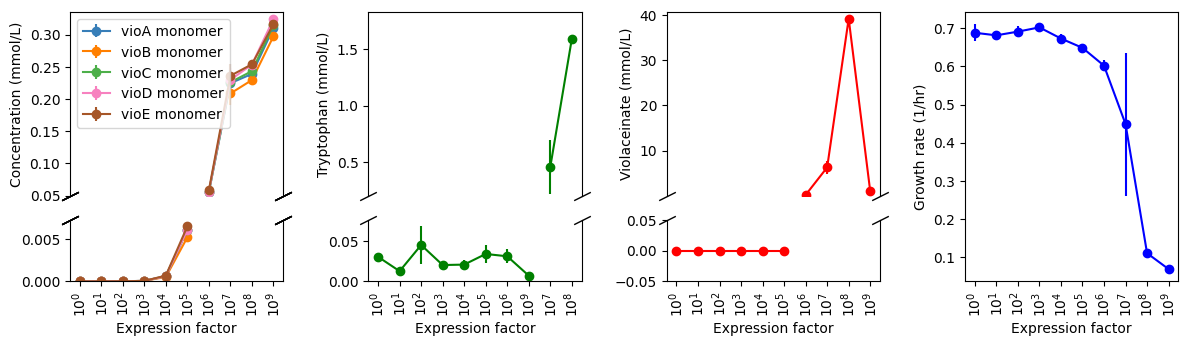

In [88]:
from matplotlib import gridspec

df_gs = dfg.groupby(["expression_level", "tr_eff"])[cols]
mapping = {"1":"$10^0$", "10":"$10^1$", "100":"$10^2$", "1000":"$10^3$", "10000":"$10^4$", "100000":"$10^5$", "1000000":"$10^6$", 
           "10000000":"$10^7$", '100000000':"$10^8$", "1000000000":"$10^9$", "10000000000":"$10^10$",}

means = df_gs.mean().reset_index()
counts = df_gs.size().reset_index()
std = df_gs.std().reset_index()
errors = std.copy()
errors[cols] = std[cols] / np.sqrt(counts[0].values[:, np.newaxis])

means["expression_level"] = means["expression_level"].map(mapping)
errors["expression_level"] = errors["expression_level"].map(mapping)

ordered_labels = ["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$", "$10^6$", "$10^7$", "$10^8$", "$10^9$", "$10^{10}$"]
means["expression_level"] = pd.Categorical(means["expression_level"], categories=ordered_labels, ordered=True)
errors["expression_level"] = pd.Categorical(errors["expression_level"], categories=ordered_labels, ordered=True)

# Sort by expression_level
means = means.sort_values("expression_level")
errors = errors.loc[means.index]  # maintain alignment

# Set break points
breaks = {
    "vio_up": 0.05,
    "vio_down": 0.009,
    "trp_up": 0.2,
    "trp_down": 0.2,
    "viol_up": 0.03,
    "viol_down": 0.03
}

# Create figure and gridspec
fig = plt.figure(figsize=(14.3, 3.5))
gs = gridspec.GridSpec(2, 4, height_ratios=[3, 1], wspace=0.4)

# Create broken axes
ax1_top = fig.add_subplot(gs[0, 0])
ax1_bottom = fig.add_subplot(gs[1, 0], sharex=ax1_top)

ax2_top = fig.add_subplot(gs[0, 1])
ax2_bottom = fig.add_subplot(gs[1, 1], sharex=ax2_top)

ax3_top = fig.add_subplot(gs[0, 2])
ax3_bottom = fig.add_subplot(gs[1, 2], sharex=ax3_top)

ax4 = fig.add_subplot(gs[:, 3])  

# Define break indicator line style
d = 0.5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

# Plot for VioA–E
plot_broken(ax1_top, ax1_bottom, "NG-VioA-MONOMER[c]", "vioA monomer", "#377eb8", breaks["vio_up"], breaks["vio_down"])
plot_broken(ax1_top, ax1_bottom, "NG-VioB-MONOMER[c]", "vioB monomer", "#ff7f00", breaks["vio_up"], breaks["vio_down"])
plot_broken(ax1_top, ax1_bottom, "NG-VioC-MONOMER[c]", "vioC monomer", "#4daf4a", breaks["vio_up"], breaks["vio_down"])
plot_broken(ax1_top, ax1_bottom, "NG-VioD-MONOMER[c]", "vioD monomer", "#f781bf", breaks["vio_up"], breaks["vio_down"])
plot_broken(ax1_top, ax1_bottom, "NG-VioE-MONOMER[c]", "vioE monomer", "#a65628", breaks["vio_up"], breaks["vio_down"])

ax1_top.set_ylabel("Concentration (mmol/L)")
ax1_bottom.set_xlabel("Expression factor")
ax1_bottom.tick_params(axis='x', rotation=90)
ax1_top.legend()

# TRP
plot_broken(ax2_top, ax2_bottom, "TRP[c]", "TRP", "g", breaks["trp_up"], breaks["trp_down"])
ax2_top.set_ylabel("Tryptophan (mmol/L)")
ax2_bottom.set_xlabel("Expression factor")
ax2_bottom.tick_params(axis='x', rotation=90)

# VIO
plot_broken(ax3_top, ax3_bottom, "CPD-14324[c]", "Violaceinate", "r", breaks["viol_up"], breaks["viol_down"])
ax3_top.set_ylabel("Violaceinate (mmol/L)")
ax3_bottom.set_xlabel("Expression factor")
ax3_bottom.tick_params(axis='x', rotation=90)

# Growth rate
ax4.errorbar(means["expression_level"], means["growth"], yerr=errors["growth"], fmt='-o', color='b')
ax4.set_xlabel("Expression factor")
ax4.set_ylabel("Growth rate (1/hr)")
ax4.tick_params(axis='x', rotation=90)

# Tight layout
fig.tight_layout()
fig.savefig('kis_cconc_metab_br.pdf', dpi=300)

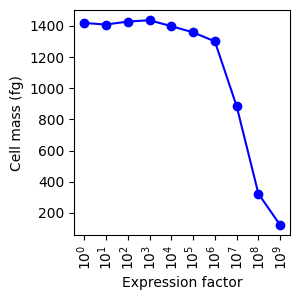

In [89]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(means["expression_level"], means["cell_mass"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("Cell mass (fg)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('meta_cell_mass.png', dpi=300)

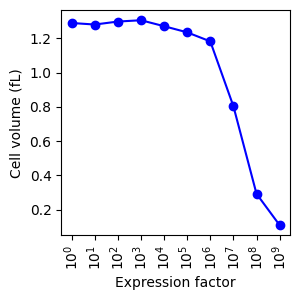

In [90]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(means["expression_level"], means["cell_volume"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("Cell volume (fL)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('meta_cell_volume.png', dpi=300)

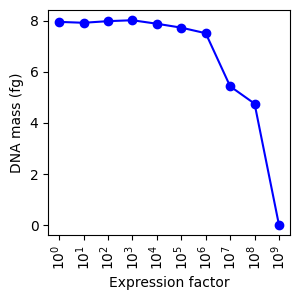

In [91]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(means["expression_level"], means["dnaMass"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("DNA mass (fg)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('meta_dna_mass.png', dpi=300)

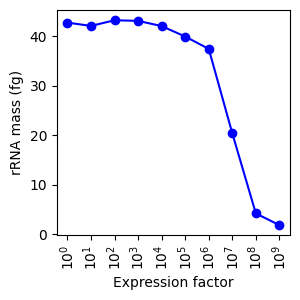

In [92]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(means["expression_level"], means["rRnaMass"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("rRNA mass (fg)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('meta_rrna_mass.png', dpi=300)

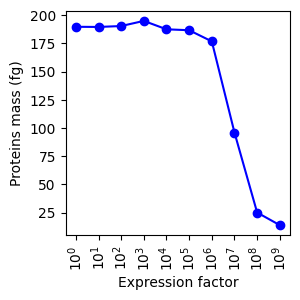

In [93]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(means["expression_level"], means["proteinMass"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("Proteins mass (fg)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('meta_protein_mass.png', dpi=300)

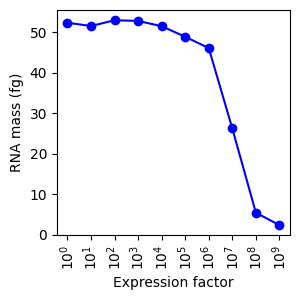

In [94]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(means["expression_level"], means["rnaMass"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("RNA mass (fg)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('meta_rna_mass.png', dpi=300)

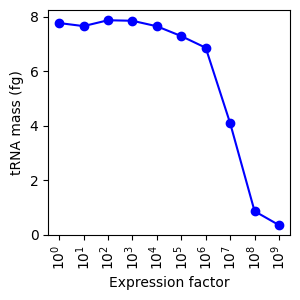

In [95]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(means["expression_level"], means["tRnaMass"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("tRNA mass (fg)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('meta_trna_mass.png', dpi=300)

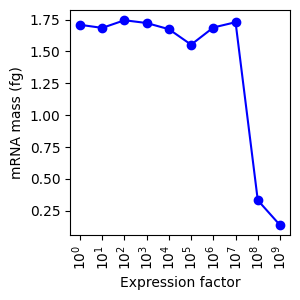

In [96]:
plt.rcParams["figure.figsize"] = (3.1, 3.1)


plt.plot(means["expression_level"], means["mRnaMass"], "-o", color="b")
plt.xlabel("Expression factor")
plt.ylabel("mRNA mass (fg)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('meta_mrna_mass.png', dpi=300)

## Statistical analysis

In [97]:
cols = df_ki.drop(columns=['tRnaMass', 'mRnaMass', 'proteinMass', 'rRnaMass', 'dnaMass', 'rnaMass', 'cell_path', 'cell_mass', 'cell_volume', 'growth',
       'variant', 'generation', 'expression_level', 'tr_eff', 'seed', "NG-VioA-MONOMER[c]", "NG-VioB-MONOMER[c]", "NG-VioC-MONOMER[c]", "NG-VioD-MONOMER[c]", "NG-VioE-MONOMER[c]"]).columns

In [98]:
import pandas as pd
import numpy as np
from scipy.stats import levene, shapiro, mannwhitneyu, ttest_ind

dfg = df_ki.drop(columns=["cell_path", "variant", "generation"]).groupby(["expression_level", "tr_eff", "seed"])[cols].mean().reset_index()


df_control = dfg[dfg['expression_level']=='1000000'][cols]
dfg = dfg[dfg['expression_level']=='10000000'][cols]

# Remove constant columns from both datasets
constant_columns_wt = list(df_control.columns[df_control.std() == 0])
constant_columns_m = list(dfg.columns[dfg.std() == 0])

constant_columns = list(set(constant_columns_wt) & set(constant_columns_m))
df_control = df_control.drop(columns=constant_columns+[ 'RPOE-MONOMER[c]'], errors='ignore')
dfg = dfg.drop(columns=constant_columns+[ 'RPOE-MONOMER[c]'], errors='ignore')
print(len(dfg), len(df_control), len(df_control.columns))

# Setup
significance_threshold = 0.0005
log2_fc_threshold = np.log2(1.5)  # Equivalent to 1.5x fold change

results = {}
significant_parametric = []
significant_non_parametric = []
norm = []

for col in df_control.columns:
    data_control = df_control[col].dropna()
    data_dfg = dfg[col].dropna()

    mean_control = data_control.mean()
    mean_dfg = data_dfg.mean()
    
    if mean_control == 0:
        log2_fc = np.inf if mean_dfg > 0 else -np.inf
    else:
        log2_fc = np.log2(mean_dfg / mean_control) if mean_dfg > 0 else -np.inf

    # Normality tests
    stat_wt, p_wt = shapiro(data_control)
    stat_mut, p_mut = shapiro(data_dfg)

    if p_wt > 0.05 and p_mut > 0.05:
        norm.append(col)
        stat_lev, p_lev = levene(data_control, data_dfg)
        use_pooled = p_lev > 0.05

        _, p = standardize_mean_differences(data_control, data_dfg, use_pooled=use_pooled)

        if p <= significance_threshold and abs(log2_fc) >= log2_fc_threshold:
            significant_parametric.append((col, p, log2_fc))
    else:
        stat, p = mannwhitneyu(data_control, data_dfg, alternative='two-sided')
        if p < significance_threshold and abs(log2_fc) >= log2_fc_threshold:
            significant_non_parametric.append((col, p, log2_fc))
        results[col] = {'Mann-Whitney Statistic': stat, 'P-Value': p, 'log2FC': log2_fc}
    

18 19 5603


In [99]:
print(len(significant_parametric), len(significant_non_parametric))

1668 1022


In [100]:
significant_non_parametric = [col for col, *_ in significant_non_parametric]
significant_parametric= [col for col, *_ in significant_parametric]
print(len(significant_parametric), len(significant_non_parametric))

1668 1022


In [101]:
# Function to compare concentrations and determine the direction of change
increase = []

# Analyze and print the direction of changes for parametric significant molecules
direction_parametric = compare_concentrations(df_control, dfg, significant_parametric)
for k,v in direction_parametric.items():
    if v=='Increase':
        increase.append(k)

# Analyze and print the direction of changes for non-parametric significant molecules
direction_non_parametric = compare_concentrations(df_control, dfg, significant_non_parametric)
for k,v in direction_non_parametric.items():
    if v=='Increase':
       increase.append(k)

In [102]:
parametric_no_meta = significant_parametric_no_meta
non_parametric_no_meta = significant_non_parametric_no_meta
no_meta_increase = ['polymerized_CTP[c]',
 'polymerized_GTP[c]',
 'ASN[c]',
 'GLUSYNLARGE-MONOMER[c]',
 'HIS[c]',
 'ILE[c]',
 'LEU[c]',
 'LYS[c]',
 'RRFA-RRNA[c]',
 'RRLA-RRNA[c]',
 'RRSA-RRNA[c]',
 'THR[c]',
 'UPPSYN-MONOMER[c]',
 'VAL[c]',
 'cysT-tRNA[c]']

In [103]:
print(len(parametric_no_meta), len(non_parametric_no_meta), len(no_meta_increase))

1730 695 15


In [104]:
no_meta = non_parametric_no_meta + parametric_no_meta
no_meta_decrease = set(no_meta) - set(no_meta_increase)
meta = significant_non_parametric + significant_parametric
meta_decrease = set(meta) - set(increase)

In [105]:
print(len(significant_parametric), len(significant_non_parametric), len(increase))

1668 1022 24


In [106]:
increase_in_both = set(no_meta_increase) & set(increase)
increase_in_meta_decrease_no_meta = set(increase) & set(no_meta_decrease)
increase_in_meta_not_in_no_meta = set(increase) - set(no_meta)


print('Increase in both \'with metabolic pathway\' and without ', len(increase_in_both))
print('Increase in \'with metabolic pathway\' and decrease in \'without\' ', len(increase_in_meta_decrease_no_meta))
print('Increase in \'with metabolic pathway\' and not significant in \'without\'', len(increase_in_meta_not_in_no_meta))

Increase in both 'with metabolic pathway' and without  9
Increase in 'with metabolic pathway' and decrease in 'without'  0
Increase in 'with metabolic pathway' and not significant in 'without' 15


In [107]:
increase_in_both

{'ASN[c]',
 'HIS[c]',
 'LEU[c]',
 'LYS[c]',
 'RRFA-RRNA[c]',
 'RRLA-RRNA[c]',
 'RRSA-RRNA[c]',
 'THR[c]',
 'VAL[c]'}

In [108]:
increase_in_meta_not_in_no_meta

{'AMMONIUM[c]',
 'ARG[c]',
 'CPD-14319[c]',
 'CPD-14320[c]',
 'CPD-14323[c]',
 'CPD-14324[c]',
 'CPD-19471[c]',
 'HYDROGEN-PEROXIDE[c]',
 'MET[c]',
 'PHE[c]',
 'S-ADENOSYLMETHIONINE[c]',
 'TYR[c]',
 'tyrT-tRNA[c]',
 'tyrU-tRNA[c]',
 'tyrV-tRNA[c]'}

In [109]:
decrease_in_both = set(no_meta_decrease) & set(meta_decrease)
decrease_in_meta_increase_no_meta = set(meta_decrease) & set(no_meta_increase)
decrease_in_meta_not_significant_no_meta = set(meta_decrease) - set(no_meta)

print('Decrease in both \'with metabolic pathway\' and without ', len(decrease_in_both))
print('Decrease in \'with metabolic pathway\' and increase in \'without\' ', len(decrease_in_meta_increase_no_meta))
print('Decrease in \'with metabolic pathway\' and not significant in \'without\'', len(decrease_in_meta_not_significant_no_meta))

Decrease in both 'with metabolic pathway' and without  2213
Decrease in 'with metabolic pathway' and increase in 'without'  0
Decrease in 'with metabolic pathway' and not significant in 'without' 453


In [110]:
file_path = "genes_ecocyc.txt"  
df_eco = pd.read_csv(file_path, sep="\t")  

df_eco['Product'] = df_eco['Product'].str.split(' // ')

df_eco = df_eco.explode('Product')

### On new molecules

In [111]:
len(decrease_in_meta_not_significant_no_meta)

453

In [112]:
monomers_dec, complex_dec, others_dec, rna_dec, peptide_dec = split_molecules_by_function(decrease_in_meta_not_significant_no_meta)

In [113]:
df_significant = pd.DataFrame(columns=['Molecule name', 'Parametric', 'Non-parametric', 'Increasing/decreasing', 'Gene'])
df_significant['Molecule name'] = significant_parametric + significant_non_parametric
df_significant['Parametric'] = [True if x in significant_parametric else False for x in list(df_significant['Molecule name'])]
df_significant['Non-parametric'] = [True if x in significant_non_parametric else False for x in list(df_significant['Molecule name'])]
df_significant['Increasing/decreasing'] = ['Increasing' if x in increase else 'Decreasing' for x in list(df_significant['Molecule name'])]

In [114]:
df_mon = df_eco[(df_eco['Product'].isin(monomers_dec)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(monomers_dec))]
print(set(monomers_dec) - set(df_mon['Product']) - set(df_mon['Gene products (complexes, polypeptides, and RNAs)']) - set([remove_brackets(x) for x in increase]))
mon_dict = {'MONOMER-2720':'cbl', 'MONOMER0-163':'tyrR', 'MONOMER0-162':'tyrR'}

for k in set(monomers_dec) - set(df_mon['Product']) - set(df_mon['Gene products (complexes, polypeptides, and RNAs)']):
    if k in mon_dict.keys():
        df_mon = pd.concat([df_mon, df_eco[(df_eco['Common-Name']==mon_dict[k])]])
    else:
        print(k)

{'MONOMER-2720', 'PHOSPHO-BASS-FE+3-CPLX'}
PHOSPHO-BASS-FE+3-CPLX


In [115]:
comp_dict = {'ACETYL-COA-CARBOXYLTRANSFER-CPLX':'',
 'ACSERLYA-CPLX': 'cysK',
 'ALAS-CPLX': 'alaS',
 'APORNAP-CPLX': '',
 'ARCB-CPLX': 'arcB',
 'ARCB-OXYGEN-CPLX': '',
 'ATOD-CPLX': 'atoD',
 'ATPA-CPLX': 'atpA',
 'ATPD-CPLX': 'atpD',
 'ATPE-CPLX': 'atpE',
 'ATPF-CPLX': 'atpF',
 'BASS-FE+3-CPLX': '',
 'BIOTIN-CARBOXYL-CPLX': 'accC',
 'CPLX-157': '',
 'CPLX0-0': 'dnaT',
 'CPLX0-10427': 'ptrR',
 'CPLX0-1161': 'hslU',
 'CPLX0-1321': '',
 'CPLX0-226': 'crp',
 'CPLX0-2361': '',
 'CPLX0-2541': 'modE',
 'CPLX0-3': '',
 'CPLX0-3102': 'clpX',
 'CPLX0-3104':'',
 'CPLX0-3107':'',
 'CPLX0-3108':'',
 'CPLX0-3461':'rne',
 'CPLX0-3521':'pnp',
 'CPLX0-3541':'rhlB',
 'CPLX0-3621': 'dnaB',
 'CPLX0-3781': '',
 'CPLX0-3953': '',
 'CPLX0-3956': '',
 'CPLX0-3962': '',
 'CPLX0-7418': 'mprA',
 'CPLX0-7605': 'iclR',
 'CPLX0-7608': 'mnmE',
 'CPLX0-7628': '',
 'CPLX0-7666': 'caiF',
 'CPLX0-7669': 'argP',
 'CPLX0-7670': 'argP',
 'CPLX0-7679': 'zur',
 'CPLX0-7710': 'marR',
 'CPLX0-7733': 'asnC',
 'CPLX0-7740': 'cytR',
 'CPLX0-7745': 'murR',
 'CPLX0-7756': 'csrA',
 'CPLX0-7759': 'metR',
 'CPLX0-7796': 'metJ',
 'CPLX0-7796APO': '',
 'CPLX0-7823': '',
 'CPLX0-7854': 'treR',
 'CPLX0-7910': '',
 'CPLX0-7921': 'manX',
 'CPLX0-7928': 'relB',
 'CPLX0-7929': 'yefM',
 'CPLX0-7942': '',
 'CPLX0-7956': 'csrA',
 'CPLX0-7964': 'tolC',
 'CPLX0-7998': 'rapZ',
 'CPLX0-8095': 'rnlA',
 'CPLX0-8102': 'tar',
 'CPLX0-8103': 'tsr',
 'CPLX0-8104': 'tap',
 'CPLX0-8105': 'trg',
 'CPLX0-8196': 'minC',
 'CPLX0-8206': 'dhaM',
 'CPLX0-8218': 'dosC',
 'CPLX0-8234': 'frmR',
 'CPLX0-8256': 'hupA',
 'CPLX0-8285': 'ompR',
 'CPLX0-8288': 'cusS',
 'CPLX0-8302': 'barA',
 'CPLX0-8309': 'pyrR',
 'CPLX0-8311': 'yoeB',
 'CPLX0-841': 'mazE',
 'CPLX0-8576': 'frlR',
 'CPLX0-8578': 'dgoR',
 'CPLX0-8593': 'nanR',
 'CPLX0-8597': 'rcdA',
 'CPLX0-881': 'clpA',
 'CPLX0-9318': 'ptrR',
 'E3-CPLX': 'lpd',
 'ENOLASE-CPLX': 'eno',
 'ENTE-CPLX': 'entE',
 'F-O-CPLX': '',
 'GCVP-CPLX': 'gcvP',
 'NRDF-CPLX': 'nrdF',
 'PHOQ-CA+2-CPLX': '',
 'PIIPROTEIN-CPLX': 'glnB',
 'SECE-G-Y-CPLX': '', 
 'CPLX0-8595': 'chbR',
 'CPLX0-7731': 'paaX', 
 'CPLX0-7696': 'mukB',
 'CPLX0-8314': 'evgS',
 'CPLX0-10308': 'phnL',
 'CPLX0-7713': 'dsdC',
 'TORS-CPLX': 'torS',
 'CPLX0-7817': 'grxD',
 'CPLX-9493': '',
 'E1P-CPLX': 'aceE',
 'CPLX0-3561': 'hypB',
 'PII2-CPLX': 'glnK',
 'B1-CPLX': 'nrdA', 
 'PHOR-Pi-CPLX': '',
 'RIBONUCLEOSIDE-TRIP-REDUCT-CPLX': 'nrdD',
 'CPLX0-8275': 'glrK', 
 'CPLX0-8199': 'dosP',
 'CITRYLY-CPLX': 'citE',
 'CPLX0-8173': 'cas2',
 'CPLX0-8181': '', 'PII2-CPLX':'glnK', 'CPLX0-8199':'dosP', 'RIBONUCLEOSIDE-TRIP-REDUCT-CPLX':'nrdD', 'CPLX0-10308':'phnL', 'CPLX0-7696':'mukB', 'PHOR-Pi-CPLX':'', 'CPLX0-8595':'chbR', 'CPLX0-7731':'paaX', 
             'CPLX0-8181':'', 'TORS-CPLX':'torS', 'CITRYLY-CPLX':'citE', 'CPLX0-8173':'cas2', 'CPLX0-8275':'glrK', 'CPLX0-8218':'dosC',
             'CPLX0-8309':'pyrR', 'CPLX0-8104':'tap', 'ARCB-OXYGEN-CPLX': ''}

In [116]:
df_com = df_eco[(df_eco['Product'].isin(complex_dec)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(complex_dec))]
print(set(complex_dec) - set(df_com['Gene products (complexes, polypeptides, and RNAs)']) -  set(df_com['Product']))

for k in set(complex_dec) - set(df_com['Gene products (complexes, polypeptides, and RNAs)']) -  set(df_com['Gene products (complexes, polypeptides, and RNAs)']):
    if k in comp_dict.keys():
        df_com = pd.concat([df_com, df_eco[(df_eco['Common-Name']==comp_dict[k])]])
    else:
        print(k)

{'CPLX0-7679', 'CPLX0-8311', 'CPLX0-8105', 'PHOR-Pi-CPLX', 'CPLX0-0', 'ARCB-OXYGEN-CPLX', 'CPLX0-8576', 'CPLX0-8104', 'CPLX0-881', 'CPLX0-7731', 'CPLX0-8288', 'CPLX0-8181', 'CPLX0-8095', 'CPLX0-7817', 'CPLX0-8595', 'CPLX0-8309'}


In [117]:
df_pep = df_eco[(df_eco['Product'].isin(peptide_dec)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(peptide_dec))]
set(peptide_dec) - set(df_pep['Product']) - set(df_pep['Gene products (complexes, polypeptides, and RNAs)'])

set()

In [118]:
df_rna = df_eco[(df_eco['Product'].isin(rna_dec)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(rna_dec))]
df_rna = pd.concat([df_rna, df_eco[(df_eco['Common-Name']=='metW') | (df_eco['Common-Name']=='metZ')]])
set(rna_dec) - set(df_rna['Product']) - set(df_rna['Gene products (complexes, polypeptides, and RNAs)'])


set()

In [119]:
df_others = df_eco[(df_eco['Product'].isin(others_dec)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(others_dec))]
set(others_dec) - set(df_others['Product']) - set(df_others['Gene products (complexes, polypeptides, and RNAs)'])


{'CHORISMATE', 'CPD-12115', 'METHYLENE-THF', 'REDUCED-MENAQUINONE'}

In [120]:
df_gene_d = pd.concat([df_others, df_rna, df_pep, df_com, df_mon])

In [121]:
genes = [x if x not in ['dicD', 'hipH',   'pqqU',  'trhA',  'lptM'] else df_gene_d[df_gene_d['Common-Name']==x]['Synonyms'].str.split(' // ').str[0].values[0] for x in list(df_gene_d['Common-Name'])]
df_go = go_it(genes)

input genes: 468
insAB2
insAB4
insAB5
insCD4
srsR
thrP
mapped genes: 462

Runing BP Ontology Analysis: current study set of 462 IDs.
 76%    344 of    450 study items found in association
 97%    450 of    462 study items found in population(4640)
Calculating 1,760 uncorrected p-values using fisher_scipy_stats
   1,760 terms are associated with  3,298 of  4,640 population items
     563 terms are associated with    344 of    450 study items
  METHOD fdr_bh:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): statsmodels fdr_bh
       8 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 462 IDs.
 67%    302 of    450 study items found in association
 97%    450 of    462 study items found in population(4640)
Calculating 261 uncorrected p-values using fisher_scipy_stats
     261 terms are associated with  3,002 of  4,640 population ite

In [122]:
df_go.head()

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes
0,GO:0060003,copper ion export,biological_process,0.000087,0.030766,4,450,4,"[cusC, cusF, cusB, cusA]"
1,GO:0006878,intracellular copper ion homeostasis,biological_process,0.000087,0.030766,4,450,4,"[cusC, cusF, cusB, cusA]"
2,GO:0015765,methylgalactoside transport,biological_process,0.000087,0.030766,4,450,4,"[mglB, melB, mglA, mglC]"
3,GO:1902601,silver ion transmembrane transport,biological_process,0.000087,0.030766,4,450,4,"[cusC, cusF, cusB, cusA]"
4,GO:0010272,response to silver ion,biological_process,0.000087,0.030766,4,450,4,"[cusC, cusF, cusB, cusA]"


In [123]:
list(df_go['term'])

['copper ion export',
 'intracellular copper ion homeostasis',
 'methylgalactoside transport',
 'silver ion transmembrane transport',
 'response to silver ion']

In [124]:
df = df_go.copy()
# Generate a LaTeX file with sections instead of a table
with open('go_terms_diff.tex', 'w') as f:
    f.write(r'\section*{GO Term Analysis}' + '\n\n')
    
    for _, row in df.iterrows():
        f.write(f"\\subsection*{{GO:{row['GO']} - {row['term']}}}\n")
        f.write(f"\\textbf{{Class:}} {row['class']}\\\\n")
        f.write(f"\\textbf{{p-value:}} {row['p']}\\\\n")
        f.write(f"\\textbf{{Number of GO terms:}} {row['n_go']}\\\\n")
        f.write(f"\\textbf{{Genes:}}\n\\small\\raggedright\n{row['study_genes']}\n\n")
        f.write(r'\vspace{1em}' + '\n')

### On all molecules

In [125]:
len(meta_decrease)

2666

In [126]:
monomers, complex, others, rna, peptide = split_molecules_by_function(meta_decrease)

In [127]:
df_significant = pd.DataFrame(columns=['Molecule name', 'Parametric', 'Non-parametric', 'Increasing/decreasing', 'Gene'])
df_significant['Molecule name'] = significant_parametric + significant_non_parametric
df_significant['Parametric'] = [True if x in significant_parametric else False for x in list(df_significant['Molecule name'])]
df_significant['Non-parametric'] = [True if x in significant_non_parametric else False for x in list(df_significant['Molecule name'])]
df_significant['Increasing/decreasing'] = ['Increasing' if x in increase else 'Decreasing' for x in list(df_significant['Molecule name'])]

In [128]:
# For monomers and dimers we do gene ontology analysis
monomers = list(set(monomers) - set([remove_brackets(x) for x in increase]))
print(len(monomers))
df_mon = df_eco[(df_eco['Product'].isin(monomers)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(monomers))]
print(len(df_mon))


1841
1838


In [129]:
set(monomers) - set(df_mon['Product']) - set(df_mon['Gene products (complexes, polypeptides, and RNAs)']) - set([remove_brackets(x) for x in increase])

{'GLUTAMINESYN-OLIGOMER',
 'MONOMER-2720',
 'MONOMER0-160',
 'MONOMER0-4565',
 'PC00003',
 'PC00004',
 'PC00005',
 'PC00007',
 'PC00033',
 'PC00040',
 'PC00061',
 'PHOSPHO-BASS-FE+3-CPLX'}

In [130]:
mono_dict = {'ASPCARBREG-DIMER': 'pyrI',
 'GLUTAMINESYN-OLIGOMER': 'glnA',
 'MONOMER0-160': 'dnaA',
 'MONOMER0-4565': 'dnaA' ,
 'PC00003': 'araC',
 'PC00004': 'crp',
 'PC00005': 'argR',
 'PC00007': 'trpR',
 'PC00033': 'purR',
 'PC00040': 'cysB',
 'PC00061': 'cra',
 'PC00086': 'rhaS',
 'PHOSPHO-BASS-FE+3-CPLX': '', 
 'MONOMER0-163': 'tyrR', 
 'MONOMER-2720': 'cbl',
 'MONOMER0-162': 'tyrR'}

In [131]:
for k in set(monomers) - set(df_mon['Product']) - set(df_mon['Gene products (complexes, polypeptides, and RNAs)']):
    if k in mono_dict.keys():
        df_mon = pd.concat([df_mon, df_eco[(df_eco['Common-Name']==mono_dict[k])]])
    else:
        print(k)

In [132]:
# For monomers and dimers we do gene ontology analysis
complex = list(set(complex) - set([remove_brackets(x) for x in increase]))
print(len(complex))
df_com = df_eco[(df_eco['Product'].isin(complex)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(complex))]
print(len(df_com))

684
812


In [133]:
set(complex) - set(df_com['Gene products (complexes, polypeptides, and RNAs)']) -  set(df_com['Product'])

{'ACETYL-COA-CARBOXYLTRANSFER-CPLX',
 'ACSERLYA-CPLX',
 'ALAS-CPLX',
 'APORNAP-CPLX',
 'ARCB-CPLX',
 'ARCB-OXYGEN-CPLX',
 'ATPA-CPLX',
 'ATPD-CPLX',
 'ATPE-CPLX',
 'ATPF-CPLX',
 'BASS-FE+3-CPLX',
 'BIOTIN-CARBOXYL-CPLX',
 'CPLX-157',
 'CPLX0-0',
 'CPLX0-1161',
 'CPLX0-1321',
 'CPLX0-226',
 'CPLX0-2361',
 'CPLX0-2541',
 'CPLX0-3',
 'CPLX0-3102',
 'CPLX0-3104',
 'CPLX0-3107',
 'CPLX0-3108',
 'CPLX0-3461',
 'CPLX0-3521',
 'CPLX0-3541',
 'CPLX0-3621',
 'CPLX0-3781',
 'CPLX0-3956',
 'CPLX0-3962',
 'CPLX0-7418',
 'CPLX0-7605',
 'CPLX0-7608',
 'CPLX0-7628',
 'CPLX0-7666',
 'CPLX0-7669',
 'CPLX0-7670',
 'CPLX0-7679',
 'CPLX0-7710',
 'CPLX0-7731',
 'CPLX0-7733',
 'CPLX0-7740',
 'CPLX0-7756',
 'CPLX0-7796',
 'CPLX0-7796APO',
 'CPLX0-7817',
 'CPLX0-7823',
 'CPLX0-7854',
 'CPLX0-7910',
 'CPLX0-7921',
 'CPLX0-7929',
 'CPLX0-7942',
 'CPLX0-7956',
 'CPLX0-7964',
 'CPLX0-7998',
 'CPLX0-8095',
 'CPLX0-8102',
 'CPLX0-8103',
 'CPLX0-8104',
 'CPLX0-8105',
 'CPLX0-8181',
 'CPLX0-8196',
 'CPLX0-8218',
 'CPL

In [134]:
dict_complex = {'ACETYL-COA-CARBOXYLTRANSFER-CPLX':'',
 'ACSERLYA-CPLX': 'cysK',
 'ALAS-CPLX': 'alaS',
 'APORNAP-CPLX': '',
 'ARCB-CPLX': 'arcB',
 'ARCB-OXYGEN-CPLX': '',
 'ATOD-CPLX': 'atoD',
 'ATPA-CPLX': 'atpA',
 'ATPD-CPLX': 'atpD',
 'ATPE-CPLX': 'atpE',
 'ATPF-CPLX': 'atpF',
 'BASS-FE+3-CPLX': '',
 'BIOTIN-CARBOXYL-CPLX': 'accC',
 'CPLX-157': '',
 'CPLX0-0': 'dnaT',
 'CPLX0-10427': 'ptrR',
 'CPLX0-1161': 'hslU',
 'CPLX0-1321': '',
 'CPLX0-226': 'crp',
 'CPLX0-2361': '',
 'CPLX0-2541': 'modE',
 'CPLX0-3': '',
 'CPLX0-3102': 'clpX',
 'CPLX0-3104':'',
 'CPLX0-3107':'',
 'CPLX0-3108':'',
 'CPLX0-3461':'rne',
 'CPLX0-3521':'pnp',
 'CPLX0-3541':'rhlB',
 'CPLX0-3621': 'dnaB',
 'CPLX0-3781': '',
 'CPLX0-3953': '',
 'CPLX0-3956': '',
 'CPLX0-3962': '',
 'CPLX0-7418': 'mprA',
 'CPLX0-7605': 'iclR',
 'CPLX0-7608': 'mnmE',
 'CPLX0-7628': '',
 'CPLX0-7666': 'caiF',
 'CPLX0-7669': 'argP',
 'CPLX0-7670': 'argP',
 'CPLX0-7679': 'zur',
 'CPLX0-7710': 'marR',
 'CPLX0-7733': 'asnC',
 'CPLX0-7740': 'cytR',
 'CPLX0-7745': 'murR',
 'CPLX0-7756': 'csrA',
 'CPLX0-7759': 'metR',
 'CPLX0-7796': 'metJ',
 'CPLX0-7796APO': '',
 'CPLX0-7823': '',
 'CPLX0-7854': 'treR',
 'CPLX0-7910': '',
 'CPLX0-7921': 'manX',
 'CPLX0-7928': 'relB',
 'CPLX0-7929': 'yefM',
 'CPLX0-7942': '',
 'CPLX0-7956': 'csrA',
 'CPLX0-7964': 'tolC',
 'CPLX0-7998': 'rapZ',
 'CPLX0-8095': 'rnlA',
 'CPLX0-8102': 'tar',
 'CPLX0-8103': 'tsr',
 'CPLX0-8104': 'tap',
 'CPLX0-8105': 'trg',
 'CPLX0-8196': 'minC',
 'CPLX0-8206': 'dhaM',
 'CPLX0-8218': 'dosC',
 'CPLX0-8234': 'frmR',
 'CPLX0-8256': 'hupA',
 'CPLX0-8285': 'ompR',
 'CPLX0-8288': 'cusS',
 'CPLX0-8302': 'barA',
 'CPLX0-8309': 'pyrR',
 'CPLX0-8311': 'yoeB',
 'CPLX0-841': 'mazE',
 'CPLX0-8576': 'frlR',
 'CPLX0-8578': 'dgoR',
 'CPLX0-8593': 'nanR',
 'CPLX0-8597': 'rcdA',
 'CPLX0-881': 'clpA',
 'CPLX0-9318': 'ptrR',
 'E3-CPLX': 'lpd',
 'ENOLASE-CPLX': 'eno',
 'ENTE-CPLX': 'entE',
 'F-O-CPLX': '',
 'GCVP-CPLX': 'gcvP',
 'NRDF-CPLX': 'nrdF',
 'PHOQ-CA+2-CPLX': '',
 'PIIPROTEIN-CPLX': 'glnB',
 'SECE-G-Y-CPLX': '', 
 'CPLX0-8595': 'chbR',
 'CPLX0-7731': 'paaX', 
 'CPLX0-7696': 'mukB',
 'CPLX0-8314': 'evgS',
 'CPLX0-10308': 'phnL',
 'CPLX0-7713': 'dsdC',
 'TORS-CPLX': 'torS',
 'CPLX0-7817': 'grxD',
 'CPLX-9493': '',
 'E1P-CPLX': 'aceE',
 'CPLX0-3561': 'hypB',
 'PII2-CPLX': 'glnK',
 'B1-CPLX': 'nrdA', 
 'PHOR-Pi-CPLX': '',
 'RIBONUCLEOSIDE-TRIP-REDUCT-CPLX': 'nrdD',
 'CPLX0-8275': 'glrK', 
 'CPLX0-8199': 'dosP',
 'CITRYLY-CPLX': 'citE',
 'CPLX0-8173': 'cas2',
 'CPLX0-8181': ''}

In [135]:
for k in set(complex) - set(df_com['Gene products (complexes, polypeptides, and RNAs)']) -  set(df_com['Gene products (complexes, polypeptides, and RNAs)']):
    if k in dict_complex.keys():
        df_com = pd.concat([df_com, df_eco[(df_eco['Common-Name']==dict_complex[k])]])
    else:
        print(k)

In [136]:
# For peptides we do gene ontology analysis
peptide = list(set(peptide) - set([remove_brackets(x) for x in increase]))
print(len(peptide))
df_pep = df_eco[(df_eco['Product'].isin(peptide)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(peptide))]
print(len(df_pep))
set(peptide) - set(df_pep['Product']) - set(df_pep['Gene products (complexes, polypeptides, and RNAs)'])

35
35


set()

In [137]:
# For rnas we do gene ontology analysis
rna = list(set(rna) - set([remove_brackets(x) for x in increase]))
print(len(rna))
df_rna = df_eco[(df_eco['Product'].isin(rna)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(rna))]
print(len(df_rna))

set(rna) - set(df_rna['Product']) - set(df_rna['Gene products (complexes, polypeptides, and RNAs)'])

63
63


set()

In [138]:
df_rna = pd.concat([df_rna, df_eco[(df_eco['Common-Name']=='metY')]])# | (df_eco['Common-Name']=='metW') | (df_eco['Common-Name']=='metZ')]])

In [139]:
# For rnas we do gene ontology analysis
others = list(set(others)  - set([remove_brackets(x) for x in increase]))
print(len(others))
df_others = df_eco[(df_eco['Product'].isin(others)) | (df_eco['Gene products (complexes, polypeptides, and RNAs)'].isin(others))]
print(len(df_others))

set(others) - set(df_others['Product']) - set(df_others['Gene products (complexes, polypeptides, and RNAs)'])


43
37


{'CHORISMATE',
 'CPD-12115',
 'E2O',
 'FLAGELLAR-MOTOR-COMPLEX',
 'METHYLENE-THF',
 'REDUCED-MENAQUINONE'}

In [140]:
df_com_mon = pd.concat([df_mon, df_com, df_pep, df_rna, df_others])
len(df_com_mon)

2867

In [141]:
df_significant['Molecule name no loc'] = df_significant['Molecule name'].str.split('[').str[0]
temp_gene_products = df_com_mon[['Gene products (complexes, polypeptides, and RNAs)', 'Common-Name']]
temp_gene_products.rename(columns={'Gene products (complexes, polypeptides, and RNAs)': 'match_key'}, inplace=True)

temp_product = df_com_mon[['Product', 'Common-Name']]
temp_product.rename(columns={'Product': 'match_key'}, inplace=True)

match_df = pd.concat([temp_gene_products, temp_product])
match_df.drop_duplicates(subset=['match_key'], inplace=True)

df_significant = df_significant.merge(
    match_df,
    left_on='Molecule name no loc',
    right_on='match_key',
    how='left'
)

df_significant['Gene'] = df_significant['Common-Name']
df_significant.drop(columns=['match_key', 'Common-Name'], inplace=True)
df_significant.to_csv('significant_molecules_meta.csv')

In [142]:
print(df_significant.drop(columns=['Molecule name no loc']).to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.1f}".format,
)) 

\begin{tabular}{lrrll}
\toprule
Molecule name & Parametric & Non-parametric & Increasing/decreasing & Gene \\
\midrule
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i] & True & False & Decreasing & plsC \\
1-PFK[c] & True & False & Decreasing & fruK \\
2-DEHYDROPANTOATE-REDUCT-MONOMER[c] & True & False & Decreasing & panE \\
2-ISOPROPYLMALATESYN-MONOMER[c] & True & False & Decreasing & leuA \\
2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER[c] & True & False & Decreasing & ubiE \\
2-OCTAPRENYLPHENOL-HYDROX-MONOMER[i] & True & False & Decreasing & ubiB \\
2OXOGLUTARATEDEH-CPLX[c] & True & False & Decreasing & sucA \\
3-METHYL-2-OXOBUT-OHCH3XFER-CPLX[c] & True & False & Decreasing & panB \\
3-OXOACYL-ACP-SYNTHII-CPLX[c] & True & False & Decreasing & fabF \\
6PGLUCONDEHYDROG-CPLX[c] & True & False & Decreasing & gnd \\
6PGLUCONDEHYDROG-MONOMER[c] & True & False & Decreasing & gnd \\
6PGLUCONOLACT-MONOMER[c] & True & False & Decreasing & pgl \\
7-ALPHA-HYDROXYSTEROID-DEH-CPLX[c] & True & False & Decrea

In [143]:
len(df_significant[df_significant['Increasing/decreasing']=='Increasing'])

24

In [144]:
genes = [x if x not in ['dicD', 'hipH',   'pqqU',  'trhA',  'lptM'] else df_com_mon[df_com_mon['Common-Name']==x]['Synonyms'].str.split(' // ').str[0].values[0] for x in list(df_com_mon['Common-Name'])]
df_go = go_it(genes)
df_go['per'] = df_go.n_genes/df_go.n_go


input genes: 2867
insAB1
insAB2
insAB4
insAB5
insAB6
insCD4
insCD6
srsR
thrP
ptrR
mapped genes: 2857

Runing BP Ontology Analysis: current study set of 2857 IDs.
 79%  2,042 of  2,587 study items found in association
 91%  2,587 of  2,857 study items found in population(4640)
Calculating 1,760 uncorrected p-values using fisher_scipy_stats
   1,760 terms are associated with  3,298 of  4,640 population items
   1,479 terms are associated with  2,042 of  2,587 study items
  METHOD fdr_bh:
      43 GO terms found significant (< 0.05=alpha) ( 33 enriched +  10 purified): statsmodels fdr_bh
     685 study items associated with significant GO IDs (enriched)
     210 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 2857 IDs.
 75%  1,940 of  2,587 study items found in association
 91%  2,587 of  2,857 study items found in population(4640)
Calculating 261 uncorrected p-values using fisher_scipy_stats
     261 terms are associated with  

In [145]:
df_go.sort_values(['per', 'n_go'], ascending=[False, False])[df_go['per']>0.9]
df_go.to_csv('GO_terms_meta.csv')

In [146]:
df = df_go.sort_values(['per', 'n_go'], ascending=[False, False])
# Generate a LaTeX file with sections instead of a table
with open('go_terms_sections.tex', 'w') as f:
    f.write(r'\section*{GO Term Analysis}' + '\n\n')
    
    for _, row in df.iterrows():
        f.write(f"\\subsection*{{GO:{row['GO']} - {row['term']}}}\n")
        f.write(f"\\textbf{{Class:}} {row['class']}\\\\n")
        f.write(f"\\textbf{{p-value:}} {row['p']}\\\\n")
        f.write(f"\\textbf{{Number of GO terms:}} {row['n_go']}\\\\n")
        f.write(f"\\textbf{{Percentage:}} {row['per']}\\\\n")
        f.write(f"\\textbf{{Genes:}}\n\\small\\raggedright\n{row['study_genes']}\n\n")
        f.write(r'\vspace{1em}' + '\n')

In [147]:
from goatools.gosubdag.gosubdag import GoSubDag

significant_terms = list(df_go[df_go['per']>0.9]['GO'])
# Create a subset graph for the significant terms
gosubdag = GoSubDag(significant_terms, obodag, prt=None)

# Function to find the most general terms among a set of related terms
def find_most_general_terms(terms, gosubdag):
    general_terms = set(terms)  # Start with all terms considered as general
    for term in terms:
        # Get all children of each term in the subset graph
        children = gosubdag.rcntobj.go2descendants.get(term, set())
        # Remove any term that is a child of another term from the set of general terms
        general_terms.difference_update(children)
    return general_terms

# Use the function to filter terms
most_general_terms = find_most_general_terms(significant_terms, gosubdag)

print("Most general terms to plot:", most_general_terms)
len(most_general_terms)


Most general terms to plot: {'GO:0009425', 'GO:0006935', 'GO:0016226', 'GO:0009288', 'GO:0097216', 'GO:0071973', 'GO:0006364', 'GO:0090529', 'GO:0042254', 'GO:0006412', 'GO:1990228', 'GO:0009228', 'GO:0043165', 'GO:0045454', 'GO:0005840', 'GO:0044781', 'GO:0046688', 'GO:0006826', 'GO:0008360', 'GO:1990904', 'GO:0032153', 'GO:0000049', 'GO:0003735', 'GO:0098797', 'GO:0043022', 'GO:0006164', 'GO:0008033', 'GO:0006633', 'GO:0009295', 'GO:0006401', 'GO:0006418', 'GO:0000028', 'GO:0019843', 'GO:0043093'}


34

[[0.         1.         1.         ... 0.81300813 0.90434783 0.94354839]
 [1.         0.         1.         ... 0.78571429 1.         1.        ]
 [1.         1.         0.         ... 1.         1.         1.        ]
 ...
 [0.81300813 0.78571429 1.         ... 0.         0.95774648 0.98717949]
 [0.90434783 1.         1.         ... 0.95774648 0.         0.92727273]
 [0.94354839 1.         1.         ... 0.98717949 0.92727273 0.        ]]


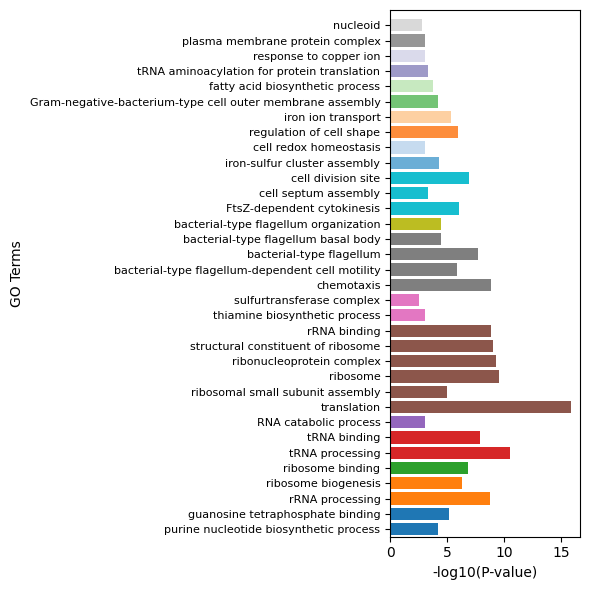

In [148]:
df_go_gen = df_go[df_go['GO'].isin(most_general_terms)]



data = df_go_gen[['GO', 'term', 'p', 'study_genes']]
# Convert p-values to negative log scale for better visualization
data['neg_log_p'] = -np.log10(data['p'])

# Create similarity matrix
similarity_matrix = np.zeros((len(data), len(data)))

for i in range(len(data)):
    for j in range(len(data)):
        similarity_matrix[i, j] = jaccard_similarity(data.iloc[i]['study_genes'], data.iloc[j]['study_genes'])

# Convert similarity to distance
distance_matrix = 1 - similarity_matrix
print(distance_matrix)


# Hierarchical clustering
linked = linkage(squareform(distance_matrix), method='complete')

from matplotlib import cm, colors
# Assign clusters at a specified cut-off value
t = 0.9  # This threshold can be adjusted
clusters = fcluster(linked, t, criterion='distance')
data['cluster'] = clusters

# Plotting the clustered GO terms with color coding
plt.figure(figsize=(6, 6))
unique_clusters = np.unique(clusters)

colors=colors.ListedColormap(cm.tab20.colors + cm.tab20c.colors, name='tab40')(np.linspace(0, 1, len(unique_clusters)))
for cluster, color in zip(unique_clusters, colors):
    clustered_data = data[(data['cluster'] == cluster) & (data['term'] != 'cytosol')]
    plt.barh(clustered_data['term'], -np.log10(clustered_data['p']), color=color)

plt.xlabel('-log10(P-value)')
plt.ylabel('GO Terms')
plt.gca().invert_yaxis()
plt.ylim(-0.5, len(data))
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('go_KO_meta_00005.png', dpi=500)

In [149]:
gos_kis = ['translation',
 'structural constituent of ribosome',
 'ribonucleoprotein complex',
 'ribosome',
 'ribosomal small subunit assembly',
 'negative regulation of translation',
 'ribosome binding',
 'tRNA aminoacylation for protein translation',
 'tRNA binding',
 'type III protein secretion system complex',
 'bacterial-type flagellum secretion apparatus',
 'bacterial-type flagellum organization',
 'bacterial-type flagellum basal body',
 'archaeal or bacterial-type flagellum-dependent cell motility',
 'bacterial-type flagellum',
 'chemotaxis',
 'sulfurtransferase complex',
 'thiamine diphosphate biosynthetic process',
 'cellular response to oxidative stress',
 'cellular oxidant detoxification',
 'cell redox homeostasis',
 'rRNA processing',
 'ribosome biogenesis',
 'iron ion transport',
 'purine nucleotide biosynthetic process',
 'iron-sulfur cluster assembly',
 'cell septum assembly',
 'tRNA modification',
 'pyrimidine nucleotide biosynthetic process',
 'plasma membrane protein complex']

In [150]:
set(list(data['term'])) - set(gos_kis)

{'FtsZ-dependent cytokinesis',
 'Gram-negative-bacterium-type cell outer membrane assembly',
 'RNA catabolic process',
 'bacterial-type flagellum-dependent cell motility',
 'cell division site',
 'fatty acid biosynthetic process',
 'guanosine tetraphosphate binding',
 'nucleoid',
 'rRNA binding',
 'regulation of cell shape',
 'response to copper ion',
 'tRNA processing',
 'thiamine biosynthetic process'}

In [151]:
set(gos_kis) - set(list(data['term']))

{'archaeal or bacterial-type flagellum-dependent cell motility',
 'bacterial-type flagellum secretion apparatus',
 'cellular oxidant detoxification',
 'cellular response to oxidative stress',
 'negative regulation of translation',
 'pyrimidine nucleotide biosynthetic process',
 'tRNA modification',
 'thiamine diphosphate biosynthetic process',
 'type III protein secretion system complex'}

In [152]:
set(increase) - set(no_meta_increase)

{'AMMONIUM[c]',
 'ARG[c]',
 'CPD-14319[c]',
 'CPD-14320[c]',
 'CPD-14323[c]',
 'CPD-14324[c]',
 'CPD-19471[c]',
 'HYDROGEN-PEROXIDE[c]',
 'MET[c]',
 'PHE[c]',
 'S-ADENOSYLMETHIONINE[c]',
 'TYR[c]',
 'tyrT-tRNA[c]',
 'tyrU-tRNA[c]',
 'tyrV-tRNA[c]'}

In [153]:
set(no_meta_increase) - set(increase)

{'GLUSYNLARGE-MONOMER[c]',
 'ILE[c]',
 'UPPSYN-MONOMER[c]',
 'cysT-tRNA[c]',
 'polymerized_CTP[c]',
 'polymerized_GTP[c]'}